In [ ]:
"""
PAN Card Tampering Detection - Complete Pipeline
Optimized for Kaggle with T4 GPU x2
"""

import os
import gc
import cv2
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import timm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_auc_score, roc_curve)
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import lightgbm as lgb

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configuration
class Config:
    # Paths - MODIFY THESE ACCORDING TO YOUR KAGGLE DATASET
    DATA_DIR = '/kaggle/input/pan-card-images-dataset/PAN dataset'  # Update this path
    REAL_DIR = os.path.join(DATA_DIR, 'Real')
    FAKE_DIR = os.path.join(DATA_DIR, 'Fake')
    
    OUTPUT_DIR = '/kaggle/working/outputs'
    MODEL_DIR = os.path.join(OUTPUT_DIR, 'models')
    PLOT_DIR = os.path.join(OUTPUT_DIR, 'plots')
    FEATURE_DIR = os.path.join(OUTPUT_DIR, 'features')
    
    # Training parameters
    IMG_SIZE = 384
    BATCH_SIZE = 16
    NUM_EPOCHS = 30
    LEARNING_RATE = 1e-4
    NUM_FOLDS = 5
    NUM_WORKERS = 4
    
    # Model parameters
    MODELS = ['efficientnet_b4', 'convnext_base', 'swin_base_patch4_window12_384']
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Augmentation
    USE_AUGMENTATION = True
    
    # Create directories
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(PLOT_DIR, exist_ok=True)
    os.makedirs(FEATURE_DIR, exist_ok=True)

print(f"Using device: {Config.DEVICE}")
print(f"Available GPUs: {torch.cuda.device_count()}")

# ==================== DATA PREPARATION ====================

def prepare_dataframe():
    """Prepare dataframe with image paths and labels"""
    data = []
    
    # Real images (label = 0)
    if os.path.exists(Config.REAL_DIR):
        real_images = [f for f in os.listdir(Config.REAL_DIR) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img in real_images:
            data.append({
                'image_path': os.path.join(Config.REAL_DIR, img),
                'label': 0,
                'class_name': 'Real'
            })
    
    # Fake images (label = 1)
    if os.path.exists(Config.FAKE_DIR):
        fake_images = [f for f in os.listdir(Config.FAKE_DIR) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img in fake_images:
            data.append({
                'image_path': os.path.join(Config.FAKE_DIR, img),
                'label': 1,
                'class_name': 'Fake'
            })
    
    df = pd.DataFrame(data)
    print(f"\nDataset Summary:")
    print(f"Total images: {len(df)}")
    print(df['class_name'].value_counts())
    
    return df

# ==================== AUGMENTATION ====================

def get_train_transforms():
    """Training augmentation pipeline"""
    return A.Compose([
        A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.OneOf([
            A.OpticalDistortion(distort_limit=0.1),
            A.GridDistortion(num_steps=5, distort_limit=0.1),
        ], p=0.3),
        A.CLAHE(clip_limit=2.0, p=0.3),
        A.ImageCompression(quality_lower=70, quality_upper=100, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_valid_transforms():
    """Validation augmentation pipeline"""
    return A.Compose([
        A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

# ==================== DATASET ====================

class PANCardDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        
        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        
        return image, torch.tensor(label, dtype=torch.long)

# ==================== FORENSIC FEATURES ====================

def extract_ela_image(image_path, quality=95):
    """Extract Error Level Analysis image"""
    try:
        img = Image.open(image_path).convert('RGB')
        
        # Save with specified quality
        temp_path = '/tmp/temp_ela.jpg'
        img.save(temp_path, 'JPEG', quality=quality)
        
        # Reload and compute difference
        compressed_img = Image.open(temp_path)
        
        # Compute ELA
        ela_img = np.array(img).astype(np.float32) - np.array(compressed_img).astype(np.float32)
        ela_img = np.abs(ela_img)
        
        # Normalize
        ela_img = (ela_img - ela_img.min()) / (ela_img.max() - ela_img.min() + 1e-8) * 255
        ela_img = ela_img.astype(np.uint8)
        
        os.remove(temp_path)
        return ela_img
    except:
        return None

def extract_forensic_features(image_path):
    """Extract forensic features from image"""
    try:
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        features = {}
        
        # Noise analysis
        noise_var = np.var(cv2.Laplacian(gray, cv2.CV_64F))
        features['noise_variance'] = noise_var
        
        # Edge density
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / edges.size
        features['edge_density'] = edge_density
        
        # JPEG quality estimation
        img_pil = Image.open(image_path)
        if hasattr(img_pil, '_getexif') and img_pil._getexif():
            features['has_exif'] = 1
        else:
            features['has_exif'] = 0
        
        # Color statistics
        for i, color in enumerate(['blue', 'green', 'red']):
            features[f'{color}_mean'] = np.mean(img[:, :, i])
            features[f'{color}_std'] = np.std(img[:, :, i])
        
        # Frequency domain features
        f_transform = np.fft.fft2(gray)
        f_shift = np.fft.fftshift(f_transform)
        magnitude = np.abs(f_shift)
        features['freq_mean'] = np.mean(magnitude)
        features['freq_std'] = np.std(magnitude)
        
        return features
    except Exception as e:
        print(f"Error extracting forensic features: {e}")
        return None

# ==================== MODEL ARCHITECTURE ====================

class PANCardClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b4', pretrained=True):
        super(PANCardClassifier, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=2)
        
    def forward(self, x):
        return self.model(x)

# ==================== TRAINING FUNCTIONS ====================

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

def train_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1), 
                         'acc': 100. * correct / total})
    
    return running_loss / len(dataloader), 100. * correct / total

def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return {
        'loss': running_loss / len(dataloader),
        'accuracy': accuracy * 100,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

def train_model(model, train_loader, valid_loader, model_name, fold, num_epochs=30):
    """Complete training loop"""
    device = Config.DEVICE
    model = model.to(device)
    
    # Use DataParallel for multi-GPU
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    
    criterion = FocalLoss(alpha=0.35, gamma=2.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_acc = 0.0
    best_model_path = os.path.join(Config.MODEL_DIR, f'{model_name}_fold{fold}_best.pth')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scheduler)
        
        # Validate
        val_metrics = validate(model, valid_loader, criterion, device)
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.2f}%")
        print(f"Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1']:.4f}")
        
        # Save best model
        if val_metrics['accuracy'] > best_acc:
            best_acc = val_metrics['accuracy']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_acc,
                'metrics': val_metrics
            }, best_model_path)
            print(f"Model saved with accuracy: {best_acc:.2f}%")
    
    # Save training history
    history_path = os.path.join(Config.PLOT_DIR, f'{model_name}_fold{fold}_history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f)
    
    # Plot training curves
    plot_training_curves(history, model_name, fold)
    
    return best_model_path, best_acc, val_metrics

def plot_training_curves(history, model_name, fold):
    """Plot training and validation curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Fold {fold} - Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{model_name} - Fold {fold} - Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(Config.PLOT_DIR, f'{model_name}_fold{fold}_curves.png'), dpi=300, bbox_inches='tight')
    plt.close()

def plot_confusion_matrix(y_true, y_pred, model_name, fold):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'])
    plt.title(f'{model_name} - Fold {fold} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.savefig(os.path.join(Config.PLOT_DIR, f'{model_name}_fold{fold}_confusion_matrix.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

def plot_roc_curve(y_true, y_probs, model_name, fold):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - Fold {fold} - ROC Curve')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(os.path.join(Config.PLOT_DIR, f'{model_name}_fold{fold}_roc_curve.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

# ==================== CROSS-VALIDATION TRAINING ====================

def train_cross_validation(df):
    """Train models with k-fold cross validation"""
    skf = StratifiedKFold(n_splits=Config.NUM_FOLDS, shuffle=True, random_state=42)
    
    all_results = []
    
    for model_name in Config.MODELS:
        print(f"\n{'='*60}")
        print(f"Training {model_name}")
        print(f"{'='*60}")
        
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
            print(f"\n--- Fold {fold+1}/{Config.NUM_FOLDS} ---")
            
            # Split data
            train_df = df.iloc[train_idx]
            val_df = df.iloc[val_idx]
            
            # Create datasets
            train_dataset = PANCardDataset(train_df, transforms=get_train_transforms())
            val_dataset = PANCardDataset(val_df, transforms=get_valid_transforms())
            
            # Create dataloaders
            train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, 
                                     shuffle=True, num_workers=Config.NUM_WORKERS, 
                                     pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, 
                                   shuffle=False, num_workers=Config.NUM_WORKERS, 
                                   pin_memory=True)
            
            # Create model
            model = PANCardClassifier(model_name=model_name, pretrained=True)
            
            # Train
            model_path, best_acc, val_metrics = train_model(
                model, train_loader, val_loader, model_name, fold, Config.NUM_EPOCHS
            )
            
            # Plot confusion matrix and ROC
            plot_confusion_matrix(val_metrics['labels'], val_metrics['predictions'], model_name, fold)
            plot_roc_curve(val_metrics['labels'], val_metrics['probabilities'], model_name, fold)
            
            fold_results.append({
                'model_name': model_name,
                'fold': fold,
                'model_path': model_path,
                'accuracy': best_acc,
                'precision': val_metrics['precision'],
                'recall': val_metrics['recall'],
                'f1': val_metrics['f1']
            })
            
            # Clear memory
            del model, train_loader, val_loader
            torch.cuda.empty_cache()
            gc.collect()
        
        # Calculate average metrics
        avg_acc = np.mean([r['accuracy'] for r in fold_results])
        avg_precision = np.mean([r['precision'] for r in fold_results])
        avg_recall = np.mean([r['recall'] for r in fold_results])
        avg_f1 = np.mean([r['f1'] for r in fold_results])
        
        print(f"\n{model_name} - Average Metrics:")
        print(f"Accuracy: {avg_acc:.2f}%")
        print(f"Precision: {avg_precision:.4f}")
        print(f"Recall: {avg_recall:.4f}")
        print(f"F1: {avg_f1:.4f}")
        
        all_results.extend(fold_results)
    
    # Save results
    results_df = pd.DataFrame(all_results)
    results_df.to_csv(os.path.join(Config.OUTPUT_DIR, 'training_results.csv'), index=False)
    
    return results_df

# ==================== ENSEMBLE PREDICTION ====================

def load_model_for_inference(model_path, model_name):
    """Load trained model for inference"""
    model = PANCardClassifier(model_name=model_name, pretrained=False)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(Config.DEVICE)
    model.eval()
    return model

def ensemble_predict(models_info, dataloader):
    """Make ensemble predictions"""
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Ensemble Prediction'):
            images = images.to(Config.DEVICE)
            
            batch_probs = []
            for model_info in models_info:
                model = model_info['model']
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                batch_probs.append(probs.cpu().numpy())
            
            # Average predictions
            avg_probs = np.mean(batch_probs, axis=0)
            all_probs.append(avg_probs)
            all_labels.extend(labels.numpy())
    
    all_probs = np.vstack(all_probs)
    predictions = np.argmax(all_probs, axis=1)
    
    return predictions, all_probs[:, 1], all_labels

def evaluate_ensemble(results_df, df):
    """Evaluate ensemble of all trained models"""
    print("\n" + "="*60)
    print("ENSEMBLE EVALUATION")
    print("="*60)
    
    # Load all models
    models_info = []
    for _, row in results_df.iterrows():
        model = load_model_for_inference(row['model_path'], row['model_name'])
        models_info.append({
            'model': model,
            'model_name': row['model_name'],
            'fold': row['fold']
        })
    
    # Create test dataset (using full dataset for demonstration)
    test_dataset = PANCardDataset(df, transforms=get_valid_transforms())
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, 
                            shuffle=False, num_workers=Config.NUM_WORKERS)
    
    # Get predictions
    predictions, probabilities, labels = ensemble_predict(models_info, test_loader)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    auc = roc_auc_score(labels, probabilities)
    
    print(f"\nEnsemble Results:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(labels, predictions, target_names=['Real', 'Fake']))
    
    # Plot final confusion matrix
    plot_confusion_matrix(labels, predictions, 'Ensemble', 'Final')
    plot_roc_curve(labels, probabilities, 'Ensemble', 'Final')
    
    # Save ensemble results
    ensemble_results = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'auc': float(auc)
    }
    
    with open(os.path.join(Config.OUTPUT_DIR, 'ensemble_results.json'), 'w') as f:
        json.dump(ensemble_results, f, indent=4)
    
    return ensemble_results

# ==================== MAIN EXECUTION ====================

def main():
    print("Starting PAN Card Tampering Detection Pipeline")
    print(f"Device: {Config.DEVICE}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    
    # Prepare data
    print("\n" + "="*60)
    print("DATA PREPARATION")
    print("="*60)
    df = prepare_dataframe()
    
    if len(df) == 0:
        print("ERROR: No images found. Please check the data paths in Config class.")
        print(f"Expected paths:\n  Real: {Config.REAL_DIR}\n  Fake: {Config.FAKE_DIR}")
        return
    
    # Train with cross-validation
    print("\n" + "="*60)
    print("TRAINING WITH CROSS-VALIDATION")
    print("="*60)
    results_df = train_cross_validation(df)
    
    # Evaluate ensemble
    ensemble_results = evaluate_ensemble(results_df, df)
    
    # Summary
    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY")
    print("="*60)
    print(f"\nOutputs saved in: {Config.OUTPUT_DIR}")
    print(f"  - Models: {Config.MODEL_DIR}")
    print(f"  - Plots: {Config.PLOT_DIR}")
    print(f"  - Results: training_results.csv, ensemble_results.json")
    
    print("\nFinal Ensemble Performance:")
    for metric, value in ensemble_results.items():
        print(f"  {metric.capitalize()}: {value:.4f}")

if __name__ == "__main__":
    main()

In [ ]:
"""
Robust Ensemble Evaluation - Handles All Edge Cases
Error-free implementation for PAN Card Detection
"""

import os
import gc
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report,
                            roc_auc_score, roc_curve, precision_recall_curve)
import warnings
warnings.filterwarnings('ignore')

# Try importing timm
try:
    import timm
    TIMM_AVAILABLE = True
except ImportError:
    print("Installing timm...")
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'timm'])
    import timm
    TIMM_AVAILABLE = True

# Try importing albumentations
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS_AVAILABLE = True
except ImportError:
    print("Installing albumentations...")
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'albumentations'])
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS_AVAILABLE = True


class Config:
    """Configuration"""
    # Update these paths for your setup
    DATA_DIR = '/kaggle/input/pan-card-images-dataset/PAN dataset'
    REAL_DIR = os.path.join(DATA_DIR, 'Real')
    FAKE_DIR = os.path.join(DATA_DIR, 'Fake')
    
    OUTPUT_DIR = '/kaggle/working/outputs'
    MODEL_DIR = os.path.join(OUTPUT_DIR, 'models1')
    PLOT_DIR = os.path.join(OUTPUT_DIR, 'plots1')
    
    IMG_SIZE = 384
    BATCH_SIZE = 16
    NUM_WORKERS = 2  # Reduced for stability
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Create directories
    for directory in [OUTPUT_DIR, MODEL_DIR, PLOT_DIR]:
        os.makedirs(directory, exist_ok=True)


print(f"Device: {Config.DEVICE}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


def safe_prepare_dataframe():
    """Safely prepare dataframe with comprehensive error handling"""
    print("\n" + "="*70)
    print("PREPARING DATASET")
    print("="*70)
    
    data = []
    
    # Process Real images
    real_count = 0
    if os.path.exists(Config.REAL_DIR):
        print(f"\nScanning Real directory: {Config.REAL_DIR}")
        for filename in os.listdir(Config.REAL_DIR):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(Config.REAL_DIR, filename)
                try:
                    # Verify image can be read
                    img = cv2.imread(img_path)
                    if img is not None and img.size > 0:
                        data.append({
                            'image_path': img_path,
                            'label': 0,
                            'class_name': 'Real',
                            'filename': filename
                        })
                        real_count += 1
                except Exception as e:
                    print(f"  Warning: Skipping {filename}: {str(e)}")
    else:
        print(f"ERROR: Real directory not found: {Config.REAL_DIR}")
    
    print(f"  Found {real_count} valid Real images")
    
    # Process Fake images
    fake_count = 0
    if os.path.exists(Config.FAKE_DIR):
        print(f"\nScanning Fake directory: {Config.FAKE_DIR}")
        for filename in os.listdir(Config.FAKE_DIR):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(Config.FAKE_DIR, filename)
                try:
                    img = cv2.imread(img_path)
                    if img is not None and img.size > 0:
                        data.append({
                            'image_path': img_path,
                            'label': 1,
                            'class_name': 'Fake',
                            'filename': filename
                        })
                        fake_count += 1
                except Exception as e:
                    print(f"  Warning: Skipping {filename}: {str(e)}")
    else:
        print(f"ERROR: Fake directory not found: {Config.FAKE_DIR}")
    
    print(f"  Found {fake_count} valid Fake images")
    
    # Create dataframe
    df = pd.DataFrame(data)
    
    if len(df) == 0:
        print("\nERROR: No valid images found!")
        print("Please check:")
        print(f"  1. Real directory exists: {Config.REAL_DIR}")
        print(f"  2. Fake directory exists: {Config.FAKE_DIR}")
        print(f"  3. Directories contain image files")
        return None
    
    # Summary
    print("\n" + "="*70)
    print("DATASET SUMMARY")
    print("="*70)
    print(f"Total images: {len(df)}")
    print(f"Real images:  {real_count} ({real_count/len(df)*100:.1f}%)")
    print(f"Fake images:  {fake_count} ({fake_count/len(df)*100:.1f}%)")
    print(f"Imbalance ratio: {real_count/fake_count:.2f}:1" if fake_count > 0 else "N/A")
    
    return df


def get_transforms():
    """Get validation transforms"""
    return A.Compose([
        A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


class SafeDataset(Dataset):
    """Dataset with error handling"""
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:
            img_path = self.df.loc[idx, 'image_path']
            label = self.df.loc[idx, 'label']
            
            # Read image
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Failed to read image: {img_path}")
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Apply transforms
            if self.transforms:
                augmented = self.transforms(image=image)
                image = augmented['image']
            
            return image, torch.tensor(label, dtype=torch.long)
        
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            # Return a blank image and label
            blank_image = torch.zeros((3, Config.IMG_SIZE, Config.IMG_SIZE))
            return blank_image, torch.tensor(0, dtype=torch.long)


class PANCardClassifier(nn.Module):
    """Model architecture"""
    def __init__(self, model_name='efficientnet_b4', pretrained=True):
        super(PANCardClassifier, self).__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=2)
        
    def forward(self, x):
        return self.model(x)


def safe_load_model(model_path, model_name):
    """Safely load model with comprehensive error handling"""
    try:
        print(f"  Loading: {os.path.basename(model_path)}")
        
        # Create model
        model = PANCardClassifier(model_name=model_name, pretrained=False)
        
        # Try different loading methods
        checkpoint = None
        try:
            # Method 1: Standard loading
            checkpoint = torch.load(model_path, map_location=Config.DEVICE)
        except Exception as e1:
            try:
                # Method 2: With weights_only=False
                checkpoint = torch.load(model_path, map_location=Config.DEVICE, weights_only=False)
            except Exception as e2:
                print(f"    Error: Could not load checkpoint - {str(e2)}")
                return None, None
        
        if checkpoint is None:
            return None, None
        
        # Extract state dict
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
            accuracy = checkpoint.get('accuracy', 0)
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
            accuracy = 0
        else:
            # Checkpoint is the state dict
            state_dict = checkpoint
            accuracy = 0
        
        # Load state dict
        try:
            model.load_state_dict(state_dict)
        except Exception as e:
            # Try to load with strict=False
            print(f"    Warning: Loading with strict=False due to: {str(e)}")
            model.load_state_dict(state_dict, strict=False)
        
        model = model.to(Config.DEVICE)
        model.eval()
        
        print(f"    Success! Accuracy: {accuracy:.2f}%")
        return model, accuracy
        
    except Exception as e:
        print(f"    Failed: {str(e)}")
        return None, None


def discover_and_load_models():
    """Discover and load all available models"""
    print("\n" + "="*70)
    print("DISCOVERING AND LOADING MODELS")
    print("="*70)
    
    if not os.path.exists(Config.MODEL_DIR):
        print(f"ERROR: Model directory not found: {Config.MODEL_DIR}")
        return []
    
    # Find all .pth files
    model_files = [f for f in os.listdir(Config.MODEL_DIR) if f.endswith('.pth')]
    
    if not model_files:
        print(f"ERROR: No .pth files found in {Config.MODEL_DIR}")
        return []
    
    print(f"\nFound {len(model_files)} model file(s)")
    
    models_info = []
    
    for model_file in sorted(model_files):
        model_path = os.path.join(Config.MODEL_DIR, model_file)
        
        # Extract model architecture name from filename
        # Expected format: modelname_foldX_best.pth or modelname_best.pth
        base_name = model_file.replace('.pth', '').replace('_best', '')
        
        # Common model names
        if 'efficientnet' in base_name.lower():
            if 'b4' in base_name.lower():
                model_name = 'efficientnet_b4'
            elif 'b3' in base_name.lower():
                model_name = 'efficientnet_b3'
            elif 'b5' in base_name.lower():
                model_name = 'efficientnet_b5'
            else:
                model_name = 'efficientnet_b4'  # default
        elif 'convnext' in base_name.lower():
            if 'base' in base_name.lower():
                model_name = 'convnext_base'
            elif 'tiny' in base_name.lower():
                model_name = 'convnext_tiny'
            else:
                model_name = 'convnext_base'
        elif 'swin' in base_name.lower():
            model_name = 'swin_base_patch4_window12_384'
        else:
            print(f"  Warning: Unknown model type for {model_file}, skipping")
            continue
        
        # Load model
        model, accuracy = safe_load_model(model_path, model_name)
        
        if model is not None:
            models_info.append({
                'model': model,
                'name': base_name,
                'model_name': model_name,
                'path': model_path,
                'accuracy': accuracy
            })
    
    print(f"\n{'='*70}")
    print(f"Successfully loaded {len(models_info)} model(s)")
    print(f"{'='*70}")
    
    if len(models_info) == 0:
        print("ERROR: No models loaded successfully!")
    
    return models_info


def generate_predictions(models_info, dataloader):
    """Generate predictions from all models"""
    print("\n" + "="*70)
    print("GENERATING PREDICTIONS")
    print("="*70)
    
    all_model_preds = {info['name']: [] for info in models_info}
    all_model_probs = {info['name']: [] for info in models_info}
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Predicting'):
            images = images.to(Config.DEVICE)
            
            for model_info in models_info:
                model = model_info['model']
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                
                all_model_preds[model_info['name']].extend(preds.cpu().numpy())
                all_model_probs[model_info['name']].extend(probs[:, 1].cpu().numpy())
            
            all_labels.extend(labels.numpy())
    
    # Convert to arrays
    for key in all_model_preds:
        all_model_preds[key] = np.array(all_model_preds[key])
        all_model_probs[key] = np.array(all_model_probs[key])
    
    all_labels = np.array(all_labels)
    
    # Ensemble predictions (average probabilities)
    all_probs_array = np.array([all_model_probs[key] for key in all_model_probs.keys()])
    ensemble_probs = np.mean(all_probs_array, axis=0)
    ensemble_preds = (ensemble_probs > 0.5).astype(int)
    
    return ensemble_preds, ensemble_probs, all_labels, all_model_preds, all_model_probs


def evaluate_metrics(predictions, labels, name="Model"):
    """Calculate evaluation metrics"""
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    return {
        'name': name,
        'accuracy': accuracy * 100,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


def print_results(results_list):
    """Print results in a formatted table"""
    print("\n" + "="*70)
    print("EVALUATION RESULTS")
    print("="*70)
    
    print(f"\n{'Model':<40} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
    print("-" * 88)
    
    for result in results_list:
        print(f"{result['name']:<40} {result['accuracy']:>10.2f}%  {result['precision']:>10.4f}  {result['recall']:>10.4f}  {result['f1']:>10.4f}")
    
    print("-" * 88)


def plot_comprehensive_evaluation(ensemble_preds, ensemble_probs, labels, 
                                  all_model_preds, all_model_probs):
    """Create comprehensive evaluation plots"""
    print("\n" + "="*70)
    print("GENERATING PLOTS")
    print("="*70)
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(labels, ensemble_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # 2. ROC Curve
    ax2 = fig.add_subplot(gs[0, 1])
    try:
        fpr, tpr, _ = roc_curve(labels, ensemble_probs)
        auc = roc_auc_score(labels, ensemble_probs)
        ax2.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.4f}')
        ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    except:
        ax2.text(0.5, 0.5, 'ROC Curve\nNot Available', ha='center', va='center')
    
    # 3. Probability Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    real_probs = ensemble_probs[labels == 0]
    fake_probs = ensemble_probs[labels == 1]
    ax3.hist(real_probs, bins=30, alpha=0.6, label='Real', color='green', density=True)
    ax3.hist(fake_probs, bins=30, alpha=0.6, label='Fake', color='red', density=True)
    ax3.axvline(0.5, color='black', linestyle='--', linewidth=2)
    ax3.set_xlabel('Fake Probability')
    ax3.set_ylabel('Density')
    ax3.set_title('Prediction Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    
    # 4. Model Comparison
    ax4 = fig.add_subplot(gs[1, 0])
    model_accs = []
    model_names_short = []
    
    for model_name, preds in all_model_preds.items():
        acc = accuracy_score(labels, preds) * 100
        model_accs.append(acc)
        # Shorten name
        short = model_name[:20] + '...' if len(model_name) > 20 else model_name
        model_names_short.append(short)
    
    # Add ensemble
    model_names_short.append('ENSEMBLE')
    model_accs.append(accuracy_score(labels, ensemble_preds) * 100)
    
    colors = ['skyblue'] * (len(model_accs) - 1) + ['gold']
    bars = ax4.barh(model_names_short, model_accs, color=colors, alpha=0.8)
    ax4.set_xlabel('Accuracy (%)')
    ax4.set_title('Model Comparison', fontsize=14, fontweight='bold')
    ax4.set_xlim([0, 105])
    ax4.grid(True, alpha=0.3, axis='x')
    
    for i, (bar, acc) in enumerate(zip(bars, model_accs)):
        ax4.text(acc + 1, bar.get_y() + bar.get_height()/2,
                f'{acc:.1f}%', va='center', fontsize=9)
    
    # 5. Precision-Recall per class
    ax5 = fig.add_subplot(gs[1, 1])
    from sklearn.metrics import precision_recall_fscore_support
    prec, rec, f1, _ = precision_recall_fscore_support(labels, ensemble_preds)
    
    x = np.arange(2)
    width = 0.25
    ax5.bar(x - width, prec, width, label='Precision', alpha=0.8)
    ax5.bar(x, rec, width, label='Recall', alpha=0.8)
    ax5.bar(x + width, f1, width, label='F1', alpha=0.8)
    ax5.set_ylabel('Score')
    ax5.set_title('Per-Class Metrics', fontsize=14, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(['Real', 'Fake'])
    ax5.legend()
    ax5.set_ylim([0, 1.1])
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Prediction Breakdown
    ax6 = fig.add_subplot(gs[1, 2])
    tn = np.sum((labels == 0) & (ensemble_preds == 0))
    fp = np.sum((labels == 0) & (ensemble_preds == 1))
    fn = np.sum((labels == 1) & (ensemble_preds == 0))
    tp = np.sum((labels == 1) & (ensemble_preds == 1))
    
    categories = ['TN\n(Real→Real)', 'FP\n(Real→Fake)', 'FN\n(Fake→Real)', 'TP\n(Fake→Fake)']
    counts = [tn, fp, fn, tp]
    colors_cat = ['green', 'orange', 'red', 'green']
    
    bars = ax6.bar(categories, counts, color=colors_cat, alpha=0.7, edgecolor='black', linewidth=2)
    ax6.set_ylabel('Count')
    ax6.set_title('Prediction Breakdown', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        pct = (count / len(labels)) * 100
        ax6.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.02,
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 7. Classification Report (text)
    ax7 = fig.add_subplot(gs[2, :])
    ax7.axis('off')
    report = classification_report(labels, ensemble_preds, target_names=['Real', 'Fake'], digits=4)
    ax7.text(0.1, 0.5, report, fontsize=11, family='monospace', va='center')
    ax7.set_title('Classification Report', fontsize=14, fontweight='bold', y=0.95)
    
    plt.suptitle('Ensemble Evaluation - Comprehensive Report', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Save
    output_path = os.path.join(Config.PLOT_DIR, 'ensemble_comprehensive_evaluation.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved: {output_path}")
    plt.close()


def main():
    """Main execution function"""
    print("="*70)
    print("ROBUST ENSEMBLE EVALUATION")
    print("="*70)
    
    # Step 1: Prepare data
    df = safe_prepare_dataframe()
    if df is None or len(df) == 0:
        print("\nExiting due to data issues")
        return
    
    # Step 2: Load models
    models_info = discover_and_load_models()
    if len(models_info) == 0:
        print("\nExiting due to model loading issues")
        return
    
    # Step 3: Create dataloader
    print("\n" + "="*70)
    print("CREATING DATALOADER")
    print("="*70)
    
    dataset = SafeDataset(df, transforms=get_transforms())
    dataloader = DataLoader(
        dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )
    print(f"Dataloader created: {len(dataloader)} batches")
    
    # Step 4: Generate predictions
    ensemble_preds, ensemble_probs, labels, all_model_preds, all_model_probs = generate_predictions(
        models_info, dataloader
    )
    
    # Step 5: Evaluate
    results_list = []
    
    # Individual models
    for model_name, preds in all_model_preds.items():
        result = evaluate_metrics(preds, labels, model_name)
        results_list.append(result)
    
    # Ensemble
    ensemble_result = evaluate_metrics(ensemble_preds, labels, "ENSEMBLE")
    results_list.append(ensemble_result)
    
    # Print results
    print_results(results_list)
    
    # Detailed classification report
    print("\n" + "="*70)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*70)
    print(classification_report(labels, ensemble_preds, target_names=['Real', 'Fake'], digits=4))
    
    # Save results
    results_df = pd.DataFrame(results_list)
    csv_path = os.path.join(Config.OUTPUT_DIR, 'ensemble_evaluation_results.csv')
    results_df.to_csv(csv_path, index=False)
    print(f"\nResults saved: {csv_path}")
    
    # Plot
    try:
        plot_comprehensive_evaluation(ensemble_preds, ensemble_probs, labels,
                                     all_model_preds, all_model_probs)
    except Exception as e:
        print(f"Warning: Plotting failed - {str(e)}")
    
    # Final summary
    print("\n" + "="*70)
    print("EVALUATION COMPLETE")
    print("="*70)
    print(f"\nFinal Ensemble Performance:")
    print(f"  Accuracy:  {ensemble_result['accuracy']:.2f}%")
    print(f"  Precision: {ensemble_result['precision']:.4f}")
    print(f"  Recall:    {ensemble_result['recall']:.4f}")
    print(f"  F1 Score:  {ensemble_result['f1']:.4f}")
    
    print(f"\nModels used: {len(models_info)}")
    print(f"Total samples: {len(labels)}")
    
    return results_df


if __name__ == "__main__":
    results = main()

In [ ]:
"""
Advanced Forensic Feature Extraction for PAN Cards
Includes ELA, Noise Analysis, JPEG Artifacts, and Statistical Features
"""

import os
import cv2
import numpy as np
from PIL import Image
import pandas as pd
from tqdm import tqdm
from scipy import fftpack
from scipy.stats import skew, kurtosis
from skimage.feature import local_binary_pattern
import pickle

class ForensicFeatureExtractor:
    """Extract forensic features for tampering detection"""
    
    def __init__(self):
        self.feature_names = []
    
    def extract_ela_features(self, image_path, quality=95):
        """Extract Error Level Analysis features"""
        try:
            img = Image.open(image_path).convert('RGB')
            
            # Save with specified quality
            temp_path = '/tmp/temp_ela.jpg'
            img.save(temp_path, 'JPEG', quality=quality)
            
            # Reload and compute difference
            compressed_img = Image.open(temp_path)
            
            # Compute ELA
            ela_img = np.array(img).astype(np.float32) - np.array(compressed_img).astype(np.float32)
            ela_img = np.abs(ela_img)
            
            # Extract statistics
            features = {
                'ela_mean': np.mean(ela_img),
                'ela_std': np.std(ela_img),
                'ela_max': np.max(ela_img),
                'ela_min': np.min(ela_img),
                'ela_median': np.median(ela_img),
                'ela_q25': np.percentile(ela_img, 25),
                'ela_q75': np.percentile(ela_img, 75)
            }
            
            os.remove(temp_path)
            return features
        except Exception as e:
            print(f"ELA extraction error: {e}")
            return {f'ela_{k}': 0 for k in ['mean', 'std', 'max', 'min', 'median', 'q25', 'q75']}
    
    def extract_noise_features(self, image):
        """Extract noise-based features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # Laplacian variance (blur detection)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # Local noise estimation
        noise = gray.astype(np.float32)
        noise_map = cv2.GaussianBlur(noise, (5, 5), 0) - noise
        
        features = {
            'noise_laplacian_var': laplacian_var,
            'noise_map_mean': np.mean(np.abs(noise_map)),
            'noise_map_std': np.std(noise_map),
            'noise_map_max': np.max(np.abs(noise_map))
        }
        
        return features
    
    def extract_edge_features(self, image):
        """Extract edge-based features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # Canny edges
        edges_low = cv2.Canny(gray, 50, 150)
        edges_high = cv2.Canny(gray, 100, 200)
        
        # Sobel gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
        
        features = {
            'edge_density_low': np.sum(edges_low > 0) / edges_low.size,
            'edge_density_high': np.sum(edges_high > 0) / edges_high.size,
            'gradient_mean': np.mean(gradient_magnitude),
            'gradient_std': np.std(gradient_magnitude),
            'gradient_max': np.max(gradient_magnitude)
        }
        
        return features
    
    def extract_color_features(self, image):
        """Extract color-based features"""
        features = {}
        
        # Per-channel statistics
        for i, color in enumerate(['blue', 'green', 'red']):
            channel = image[:, :, i] if len(image.shape) == 3 else image
            features[f'{color}_mean'] = np.mean(channel)
            features[f'{color}_std'] = np.std(channel)
            features[f'{color}_median'] = np.median(channel)
            features[f'{color}_skew'] = skew(channel.flatten())
            features[f'{color}_kurtosis'] = kurtosis(channel.flatten())
        
        # Color histogram features
        if len(image.shape) == 3:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            for i, channel_name in enumerate(['hue', 'sat', 'val']):
                features[f'{channel_name}_mean'] = np.mean(hsv[:, :, i])
                features[f'{channel_name}_std'] = np.std(hsv[:, :, i])
        
        return features
    
    def extract_frequency_features(self, image):
        """Extract frequency domain features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # FFT
        f_transform = np.fft.fft2(gray)
        f_shift = np.fft.fftshift(f_transform)
        magnitude = np.abs(f_shift)
        
        # DCT
        dct = cv2.dct(gray.astype(np.float32))
        
        features = {
            'fft_mean': np.mean(magnitude),
            'fft_std': np.std(magnitude),
            'fft_max': np.max(magnitude),
            'dct_mean': np.mean(np.abs(dct)),
            'dct_std': np.std(dct),
            'dct_energy': np.sum(dct**2)
        }
        
        return features
    
    def extract_texture_features(self, image):
        """Extract texture features using LBP"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # Local Binary Pattern
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # LBP histogram
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
        
        features = {
            'lbp_mean': np.mean(lbp),
            'lbp_std': np.std(lbp),
            'lbp_entropy': -np.sum(hist * np.log2(hist + 1e-10))
        }
        
        # GLCM-like features (simplified)
        features['texture_contrast'] = np.std(gray)
        features['texture_homogeneity'] = np.mean(gray)
        
        return features
    
    def extract_jpeg_features(self, image_path):
        """Extract JPEG-specific features"""
        try:
            img = Image.open(image_path)
            
            features = {
                'image_format': 1 if img.format == 'JPEG' else 0,
                'image_width': img.width,
                'image_height': img.height,
                'aspect_ratio': img.width / img.height if img.height > 0 else 0
            }
            
            # Check for EXIF data
            if hasattr(img, '_getexif') and img._getexif():
                features['has_exif'] = 1
            else:
                features['has_exif'] = 0
            
            return features
        except:
            return {
                'image_format': 0,
                'image_width': 0,
                'image_height': 0,
                'aspect_ratio': 0,
                'has_exif': 0
            }
    
    def extract_all_features(self, image_path):
        """Extract all forensic features"""
        try:
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {image_path}")
                return None
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Extract all feature groups
            features = {}
            features.update(self.extract_ela_features(image_path))
            features.update(self.extract_noise_features(image_rgb))
            features.update(self.extract_edge_features(image_rgb))
            features.update(self.extract_color_features(image_rgb))
            features.update(self.extract_frequency_features(image_rgb))
            features.update(self.extract_texture_features(image_rgb))
            features.update(self.extract_jpeg_features(image_path))
            
            return features
        except Exception as e:
            print(f"Error extracting features from {image_path}: {e}")
            return None
    
    def extract_from_dataframe(self, df, output_path=None):
        """Extract features for all images in dataframe"""
        all_features = []
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting forensic features"):
            features = self.extract_all_features(row['image_path'])
            if features:
                features['label'] = row['label']
                features['image_path'] = row['image_path']
                all_features.append(features)
        
        features_df = pd.DataFrame(all_features)
        
        if output_path:
            features_df.to_csv(output_path, index=False)
            print(f"Features saved to: {output_path}")
        
        return features_df


class MetaLearnerEnsemble:
    """Meta-learner for combining multiple models"""
    
    def __init__(self):
        self.xgb_model = None
        self.lgb_model = None
        self.feature_names = None
    
    def prepare_meta_features(self, cnn_predictions, forensic_features):
        """Combine CNN predictions with forensic features"""
        # CNN predictions shape: (n_samples, n_models)
        # Forensic features shape: (n_samples, n_features)
        
        meta_features = np.concatenate([cnn_predictions, forensic_features], axis=1)
        return meta_features
    
    def train(self, X_train, y_train, X_val=None, y_val=None):
        """Train meta-learner models"""
        import xgboost as xgb
        import lightgbm as lgb
        
        # XGBoost
        self.xgb_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            eval_metric='auc',
            random_state=42,
            use_label_encoder=False
        )
        
        if X_val is not None and y_val is not None:
            self.xgb_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        else:
            self.xgb_model.fit(X_train, y_train)
        
        # LightGBM
        self.lgb_model = lgb.LGBMClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary',
            metric='auc',
            random_state=42
        )
        
        if X_val is not None and y_val is not None:
            self.lgb_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        else:
            self.lgb_model.fit(X_train, y_train)
        
        print("Meta-learner training completed")
    
    def predict(self, X):
        """Make predictions using ensemble"""
        xgb_pred = self.xgb_model.predict_proba(X)[:, 1]
        lgb_pred = self.lgb_model.predict_proba(X)[:, 1]
        
        # Average predictions
        ensemble_pred = (xgb_pred + lgb_pred) / 2
        return (ensemble_pred > 0.5).astype(int), ensemble_pred
    
    def save(self, filepath):
        """Save meta-learner"""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'xgb_model': self.xgb_model,
                'lgb_model': self.lgb_model
            }, f)
        print(f"Meta-learner saved to: {filepath}")
    
    def load(self, filepath):
        """Load meta-learner"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.xgb_model = data['xgb_model']
            self.lgb_model = data['lgb_model']
        print(f"Meta-learner loaded from: {filepath}")

class Config:
    # Paths - MODIFY THESE ACCORDING TO YOUR KAGGLE DATASET
    DATA_DIR = '/kaggle/input/pan-card-images-dataset/PAN dataset'  # Update this path
    REAL_DIR = os.path.join(DATA_DIR, 'Real')
    FAKE_DIR = os.path.join(DATA_DIR, 'Fake')
    
    OUTPUT_DIR = '/kaggle/working/outputs'
    MODEL_DIR = os.path.join(OUTPUT_DIR, 'models')
    PLOT_DIR = os.path.join(OUTPUT_DIR, 'plots')
    FEATURE_DIR = os.path.join(OUTPUT_DIR, 'features')
    
    # Training parameters
    IMG_SIZE = 384
    BATCH_SIZE = 16
    NUM_EPOCHS = 30
    LEARNING_RATE = 1e-4
    NUM_FOLDS = 5
    NUM_WORKERS = 4
    
    # Model parameters
    MODELS = ['efficientnet_b4', 'convnext_base', 'swin_base_patch4_window12_384']
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Augmentation
    USE_AUGMENTATION = True
    
    # Create directories
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(PLOT_DIR, exist_ok=True)
    os.makedirs(FEATURE_DIR, exist_ok=True)

print(f"Using device: {Config.DEVICE}")
print(f"Available GPUs: {torch.cuda.device_count()}")

# ==================== DATA PREPARATION ====================

def prepare_dataframe():
    """Prepare dataframe with image paths and labels"""
    data = []
    
    # Real images (label = 0)
    if os.path.exists(Config.REAL_DIR):
        real_images = [f for f in os.listdir(Config.REAL_DIR) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img in real_images:
            data.append({
                'image_path': os.path.join(Config.REAL_DIR, img),
                'label': 0,
                'class_name': 'Real'
            })
    
    # Fake images (label = 1)
    if os.path.exists(Config.FAKE_DIR):
        fake_images = [f for f in os.listdir(Config.FAKE_DIR) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img in fake_images:
            data.append({
                'image_path': os.path.join(Config.FAKE_DIR, img),
                'label': 1,
                'class_name': 'Fake'
            })
    
    df = pd.DataFrame(data)
    print(f"\nDataset Summary:")
    print(f"Total images: {len(df)}")
    print(df['class_name'].value_counts())
    
    return df



def main():
    """Example usage"""
    import sys
    sys.path.append('/kaggle/working')
        
    print("Extracting forensic features...")
    
    # Prepare dataframe
    df = prepare_dataframe()
    
    # Extract features
    extractor = ForensicFeatureExtractor()
    features_df = extractor.extract_from_dataframe(
        df, 
        output_path=os.path.join(Config.FEATURE_DIR, 'forensic_features.csv')
    )
    
    print(f"\nExtracted {len(features_df.columns)-2} forensic features")
    print(f"Features shape: {features_df.shape}")
    print("\nSample features:")
    print(features_df.head())


if __name__ == "__main__":
    main()

In [ ]:
"""
OCR and Text Analysis Module for PAN Card Detection
Extracts and validates text from PAN cards
"""

import os
import re
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

try:
    import pytesseract
    TESSERACT_AVAILABLE = True
except:
    TESSERACT_AVAILABLE = False
    print("Warning: pytesseract not available")

try:
    import easyocr
    EASYOCR_AVAILABLE = True
except:
    EASYOCR_AVAILABLE = False
    print("Warning: easyocr not available")


class ForensicFeatureExtractor:
    """Extract forensic features for tampering detection"""
    
    def __init__(self):
        self.feature_names = []
    
    def extract_ela_features(self, image_path, quality=95):
        """Extract Error Level Analysis features"""
        try:
            img = Image.open(image_path).convert('RGB')
            
            # Save with specified quality
            temp_path = '/tmp/temp_ela.jpg'
            img.save(temp_path, 'JPEG', quality=quality)
            
            # Reload and compute difference
            compressed_img = Image.open(temp_path)
            
            # Compute ELA
            ela_img = np.array(img).astype(np.float32) - np.array(compressed_img).astype(np.float32)
            ela_img = np.abs(ela_img)
            
            # Extract statistics
            features = {
                'ela_mean': np.mean(ela_img),
                'ela_std': np.std(ela_img),
                'ela_max': np.max(ela_img),
                'ela_min': np.min(ela_img),
                'ela_median': np.median(ela_img),
                'ela_q25': np.percentile(ela_img, 25),
                'ela_q75': np.percentile(ela_img, 75)
            }
            
            os.remove(temp_path)
            return features
        except Exception as e:
            print(f"ELA extraction error: {e}")
            return {f'ela_{k}': 0 for k in ['mean', 'std', 'max', 'min', 'median', 'q25', 'q75']}
    
    def extract_noise_features(self, image):
        """Extract noise-based features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # Laplacian variance (blur detection)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # Local noise estimation
        noise = gray.astype(np.float32)
        noise_map = cv2.GaussianBlur(noise, (5, 5), 0) - noise
        
        features = {
            'noise_laplacian_var': laplacian_var,
            'noise_map_mean': np.mean(np.abs(noise_map)),
            'noise_map_std': np.std(noise_map),
            'noise_map_max': np.max(np.abs(noise_map))
        }
        
        return features
    
    def extract_edge_features(self, image):
        """Extract edge-based features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # Canny edges
        edges_low = cv2.Canny(gray, 50, 150)
        edges_high = cv2.Canny(gray, 100, 200)
        
        # Sobel gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
        
        features = {
            'edge_density_low': np.sum(edges_low > 0) / edges_low.size,
            'edge_density_high': np.sum(edges_high > 0) / edges_high.size,
            'gradient_mean': np.mean(gradient_magnitude),
            'gradient_std': np.std(gradient_magnitude),
            'gradient_max': np.max(gradient_magnitude)
        }
        
        return features
    
    def extract_color_features(self, image):
        """Extract color-based features"""
        features = {}
        
        # Per-channel statistics
        for i, color in enumerate(['blue', 'green', 'red']):
            channel = image[:, :, i] if len(image.shape) == 3 else image
            features[f'{color}_mean'] = np.mean(channel)
            features[f'{color}_std'] = np.std(channel)
            features[f'{color}_median'] = np.median(channel)
            features[f'{color}_skew'] = skew(channel.flatten())
            features[f'{color}_kurtosis'] = kurtosis(channel.flatten())
        
        # Color histogram features
        if len(image.shape) == 3:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            for i, channel_name in enumerate(['hue', 'sat', 'val']):
                features[f'{channel_name}_mean'] = np.mean(hsv[:, :, i])
                features[f'{channel_name}_std'] = np.std(hsv[:, :, i])
        
        return features
    
    def extract_frequency_features(self, image):
        """Extract frequency domain features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # FFT
        f_transform = np.fft.fft2(gray)
        f_shift = np.fft.fftshift(f_transform)
        magnitude = np.abs(f_shift)
        
        # DCT
        dct = cv2.dct(gray.astype(np.float32))
        
        features = {
            'fft_mean': np.mean(magnitude),
            'fft_std': np.std(magnitude),
            'fft_max': np.max(magnitude),
            'dct_mean': np.mean(np.abs(dct)),
            'dct_std': np.std(dct),
            'dct_energy': np.sum(dct**2)
        }
        
        return features
    
    def extract_texture_features(self, image):
        """Extract texture features using LBP"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # Local Binary Pattern
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # LBP histogram
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
        
        features = {
            'lbp_mean': np.mean(lbp),
            'lbp_std': np.std(lbp),
            'lbp_entropy': -np.sum(hist * np.log2(hist + 1e-10))
        }
        
        # GLCM-like features (simplified)
        features['texture_contrast'] = np.std(gray)
        features['texture_homogeneity'] = np.mean(gray)
        
        return features
    
    def extract_jpeg_features(self, image_path):
        """Extract JPEG-specific features"""
        try:
            img = Image.open(image_path)
            
            features = {
                'image_format': 1 if img.format == 'JPEG' else 0,
                'image_width': img.width,
                'image_height': img.height,
                'aspect_ratio': img.width / img.height if img.height > 0 else 0
            }
            
            # Check for EXIF data
            if hasattr(img, '_getexif') and img._getexif():
                features['has_exif'] = 1
            else:
                features['has_exif'] = 0
            
            return features
        except:
            return {
                'image_format': 0,
                'image_width': 0,
                'image_height': 0,
                'aspect_ratio': 0,
                'has_exif': 0
            }
    
    def extract_all_features(self, image_path):
        """Extract all forensic features"""
        try:
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {image_path}")
                return None
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Extract all feature groups
            features = {}
            features.update(self.extract_ela_features(image_path))
            features.update(self.extract_noise_features(image_rgb))
            features.update(self.extract_edge_features(image_rgb))
            features.update(self.extract_color_features(image_rgb))
            features.update(self.extract_frequency_features(image_rgb))
            features.update(self.extract_texture_features(image_rgb))
            features.update(self.extract_jpeg_features(image_path))
            
            return features
        except Exception as e:
            print(f"Error extracting features from {image_path}: {e}")
            return None
    
    def extract_from_dataframe(self, df, output_path=None):
        """Extract features for all images in dataframe"""
        all_features = []
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting forensic features"):
            features = self.extract_all_features(row['image_path'])
            if features:
                features['label'] = row['label']
                features['image_path'] = row['image_path']
                all_features.append(features)
        
        features_df = pd.DataFrame(all_features)
        
        if output_path:
            features_df.to_csv(output_path, index=False)
            print(f"Features saved to: {output_path}")
        
        return features_df


class TextFeatureExtractor:
    """Extract text features from PAN card images"""
    
    def __init__(self):
        self.pan_pattern = re.compile(r'[A-Z]{5}[0-9]{4}[A-Z]')
        self.date_patterns = [
            re.compile(r'\d{2}[/-]\d{2}[/-]\d{4}'),
            re.compile(r'\d{2}[/-]\d{2}[/-]\d{2}')
        ]
        
        if EASYOCR_AVAILABLE:
            try:
                self.easy_reader = easyocr.Reader(['en'], gpu=True)
            except:
                self.easy_reader = None
        else:
            self.easy_reader = None
    
    def preprocess_for_ocr(self, image):
        """Preprocess image for better OCR"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Denoise
        denoised = cv2.fastNlMeansDenoising(gray)
        
        # Increase contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(denoised)
        
        # Binarization
        _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        return binary
    
    def extract_text_tesseract(self, image):
        """Extract text using Tesseract"""
        if not TESSERACT_AVAILABLE:
            return "", 0.0
        
        try:
            preprocessed = self.preprocess_for_ocr(image)
            
            # Get detailed output
            data = pytesseract.image_to_data(preprocessed, output_type=pytesseract.Output.DICT)
            
            # Extract text and confidence
            text = " ".join([word for word in data['text'] if word.strip()])
            confidences = [conf for conf in data['conf'] if conf != -1]
            avg_confidence = np.mean(confidences) if confidences else 0.0
            
            return text, avg_confidence
        except Exception as e:
            print(f"Tesseract error: {e}")
            return "", 0.0
    
    def extract_text_easyocr(self, image):
        """Extract text using EasyOCR"""
        if not self.easy_reader:
            return "", 0.0
        
        try:
            results = self.easy_reader.readtext(image)
            
            text = " ".join([item[1] for item in results])
            confidences = [item[2] for item in results]
            avg_confidence = np.mean(confidences) if confidences else 0.0
            
            return text, avg_confidence
        except Exception as e:
            print(f"EasyOCR error: {e}")
            return "", 0.0
    
    def validate_pan_number(self, text):
        """Validate PAN number format"""
        matches = self.pan_pattern.findall(text.upper())
        
        if not matches:
            return {
                'has_pan': 0,
                'pan_valid_format': 0,
                'pan_count': 0,
                'pan_fourth_char_valid': 0
            }
        
        pan = matches[0]
        
        # Check 4th character (P for person, C for company, etc.)
        valid_fourth_chars = ['P', 'C', 'H', 'F', 'A', 'T', 'B', 'L', 'J', 'G']
        fourth_char_valid = 1 if pan[3] in valid_fourth_chars else 0
        
        return {
            'has_pan': 1,
            'pan_valid_format': 1,
            'pan_count': len(matches),
            'pan_fourth_char_valid': fourth_char_valid
        }
    
    def extract_date_features(self, text):
        """Extract and validate date features"""
        dates_found = []
        for pattern in self.date_patterns:
            dates_found.extend(pattern.findall(text))
        
        return {
            'has_date': 1 if dates_found else 0,
            'date_count': len(dates_found)
        }
    
    def calculate_text_quality_metrics(self, image):
        """Calculate text quality metrics"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Sharpness using Laplacian variance
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # Text region detection using adaptive threshold
        binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
        
        # Calculate text density (approximate)
        text_density = np.sum(binary < 128) / binary.size
        
        # Edge strength in text regions
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / edges.size
        
        return {
            'text_sharpness': sharpness,
            'text_density': text_density,
            'text_edge_density': edge_density
        }
    
    def analyze_font_consistency(self, image):
        """Analyze font consistency (simplified)"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect text regions
        binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 11, 2)
        
        # Find contours (characters)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) < 10:
            return {
                'char_count': len(contours),
                'char_height_std': 0,
                'char_width_std': 0,
                'char_aspect_ratio_std': 0
            }
        
        heights = []
        widths = []
        aspect_ratios = []
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > 5 and h > 5:  # Filter noise
                heights.append(h)
                widths.append(w)
                aspect_ratios.append(w / h if h > 0 else 0)
        
        return {
            'char_count': len(contours),
            'char_height_std': np.std(heights) if heights else 0,
            'char_width_std': np.std(widths) if widths else 0,
            'char_aspect_ratio_std': np.std(aspect_ratios) if aspect_ratios else 0
        }
    
    def extract_all_text_features(self, image_path):
        """Extract all text-based features"""
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {image_path}")
                return None
            
            features = {}
            
            # Extract text using available OCR engines
            text_tesseract, conf_tesseract = self.extract_text_tesseract(image)
            text_easyocr, conf_easyocr = self.extract_text_easyocr(image)
            
            # Combine texts
            combined_text = text_tesseract + " " + text_easyocr
            
            features['ocr_confidence_tesseract'] = conf_tesseract
            features['ocr_confidence_easyocr'] = conf_easyocr
            features['ocr_text_length'] = len(combined_text)
            features['ocr_word_count'] = len(combined_text.split())
            
            # Validate PAN number
            pan_features = self.validate_pan_number(combined_text)
            features.update(pan_features)
            
            # Extract date features
            date_features = self.extract_date_features(combined_text)
            features.update(date_features)
            
            # Text quality metrics
            quality_metrics = self.calculate_text_quality_metrics(image)
            features.update(quality_metrics)
            
            # Font consistency
            font_features = self.analyze_font_consistency(image)
            features.update(font_features)
            
            return features
            
        except Exception as e:
            print(f"Error extracting text features from {image_path}: {e}")
            return None
    
    def extract_from_dataframe(self, df, output_path=None):
        """Extract text features for all images in dataframe"""
        all_features = []
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting text features"):
            features = self.extract_all_text_features(row['image_path'])
            if features:
                features['label'] = row['label']
                features['image_path'] = row['image_path']
                all_features.append(features)
        
        features_df = pd.DataFrame(all_features)
        
        if output_path:
            features_df.to_csv(output_path, index=False)
            print(f"Text features saved to: {output_path}")
        
        return features_df


class AdvancedTextValidator:
    """Advanced text validation for PAN cards"""
    
    def __init__(self):
        # Common Indian names for validation
        self.common_first_names = set([
            'AMIT', 'RAHUL', 'PRIYA', 'SNEHA', 'RAJESH', 'SURESH', 
            'KUMAR', 'SINGH', 'SHARMA', 'PATEL'
        ])
        
        self.valid_pan_fourth_char = {
            'P': 'Individual',
            'C': 'Company',
            'H': 'HUF',
            'F': 'Firm',
            'A': 'AOP',
            'T': 'Trust',
            'B': 'BOI',
            'L': 'Local Authority',
            'J': 'Artificial Juridical Person',
            'G': 'Government'
        }
    
    def validate_pan_checksum(self, pan):
        """Validate PAN checksum (if algorithm is available)"""
        # Note: Actual PAN checksum algorithm is not publicly available
        # This is a placeholder for pattern validation
        if len(pan) != 10:
            return False
        
        pattern = r'^[A-Z]{5}[0-9]{4}[A-Z]$'
        return bool(re.match(pattern, pan))
    
    def validate_name_format(self, name):
        """Validate name format"""
        if not name:
            return 0
        
        # Check if name contains only alphabets and spaces
        if not re.match(r'^[A-Za-z\s]+$', name):
            return 0
        
        # Check if name has at least 2 words
        words = name.strip().split()
        if len(words) < 2:
            return 0.5
        
        return 1
    
    def calculate_text_anomaly_score(self, extracted_features):
        """Calculate anomaly score based on text features"""
        anomaly_score = 0
        
        # Missing PAN number
        if extracted_features.get('has_pan', 0) == 0:
            anomaly_score += 0.3
        
        # Multiple PAN numbers found
        if extracted_features.get('pan_count', 0) > 1:
            anomaly_score += 0.2
        
        # Invalid fourth character
        if extracted_features.get('pan_fourth_char_valid', 0) == 0:
            anomaly_score += 0.2
        
        # Low OCR confidence
        if extracted_features.get('ocr_confidence_tesseract', 100) < 60:
            anomaly_score += 0.15
        
        # High font inconsistency
        if extracted_features.get('char_height_std', 0) > 10:
            anomaly_score += 0.15
        
        return min(anomaly_score, 1.0)


def combine_all_features(cnn_features_path, forensic_features_path, text_features_path, output_path):
    """Combine all feature types into single dataframe"""
    
    # Load features
    forensic_df = pd.read_csv(forensic_features_path)
    text_df = pd.read_csv(text_features_path)
    
    # Merge on image_path
    combined_df = forensic_df.merge(text_df, on=['image_path', 'label'], how='inner')
    
    # Save combined features
    combined_df.to_csv(output_path, index=False)
    print(f"Combined features saved to: {output_path}")
    print(f"Total features: {len(combined_df.columns) - 2}")
    
    return combined_df


class Config:
    # Paths - MODIFY THESE ACCORDING TO YOUR KAGGLE DATASET
    DATA_DIR = '/kaggle/input/pan-card-images-dataset/PAN dataset'  # Update this path
    REAL_DIR = os.path.join(DATA_DIR, 'Real')
    FAKE_DIR = os.path.join(DATA_DIR, 'Fake')
    
    OUTPUT_DIR = '/kaggle/working/outputs'
    MODEL_DIR = os.path.join(OUTPUT_DIR, 'models')
    PLOT_DIR = os.path.join(OUTPUT_DIR, 'plots')
    FEATURE_DIR = os.path.join(OUTPUT_DIR, 'features')
    
    # Training parameters
    IMG_SIZE = 384
    BATCH_SIZE = 16
    NUM_EPOCHS = 30
    LEARNING_RATE = 1e-4
    NUM_FOLDS = 5
    NUM_WORKERS = 4
    
    # Model parameters
    MODELS = ['efficientnet_b4', 'convnext_base', 'swin_base_patch4_window12_384']
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Augmentation
    USE_AUGMENTATION = True
    
    # Create directories
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(PLOT_DIR, exist_ok=True)
    os.makedirs(FEATURE_DIR, exist_ok=True)

print(f"Using device: {Config.DEVICE}")
print(f"Available GPUs: {torch.cuda.device_count()}")

# ==================== DATA PREPARATION ====================

def prepare_dataframe():
    """Prepare dataframe with image paths and labels"""
    data = []
    
    # Real images (label = 0)
    if os.path.exists(Config.REAL_DIR):
        real_images = [f for f in os.listdir(Config.REAL_DIR) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img in real_images:
            data.append({
                'image_path': os.path.join(Config.REAL_DIR, img),
                'label': 0,
                'class_name': 'Real'
            })
    
    # Fake images (label = 1)
    if os.path.exists(Config.FAKE_DIR):
        fake_images = [f for f in os.listdir(Config.FAKE_DIR) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img in fake_images:
            data.append({
                'image_path': os.path.join(Config.FAKE_DIR, img),
                'label': 1,
                'class_name': 'Fake'
            })
    
    df = pd.DataFrame(data)
    print(f"\nDataset Summary:")
    print(f"Total images: {len(df)}")
    print(df['class_name'].value_counts())
    
    return df


def main():
    """Example usage"""
    import sys
    sys.path.append('/kaggle/working')
        
    print("Extracting text features...")
    
    # Prepare dataframe
    df = prepare_dataframe()
    
    # Extract features
    extractor = TextFeatureExtractor()
    features_df = extractor.extract_from_dataframe(
        df,
        output_path=os.path.join(Config.FEATURE_DIR, 'text_features.csv')
    )
    
    print(f"\nExtracted {len(features_df.columns)-2} text features")
    print(f"Features shape: {features_df.shape}")
    print("\nSample features:")
    print(features_df.head())
    
    # Combine with forensic features if available
    forensic_path = os.path.join(Config.FEATURE_DIR, 'forensic_features.csv')
    if os.path.exists(forensic_path):
        combined_df = combine_all_features(
            None,
            forensic_path,
            os.path.join(Config.FEATURE_DIR, 'text_features.csv'),
            os.path.join(Config.FEATURE_DIR, 'combined_features.csv')
        )
        print(f"\nCombined features shape: {combined_df.shape}")


if __name__ == "__main__":
    main()

In [ ]:
"""
Complete Integration Pipeline - Uses Existing Trained CNN Models
Extracts features and trains meta-learner only
"""

import os
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

class TextFeatureExtractor:
    """Extract text features from PAN card images"""
    
    def __init__(self):
        self.pan_pattern = re.compile(r'[A-Z]{5}[0-9]{4}[A-Z]')
        self.date_patterns = [
            re.compile(r'\d{2}[/-]\d{2}[/-]\d{4}'),
            re.compile(r'\d{2}[/-]\d{2}[/-]\d{2}')
        ]
        
        if EASYOCR_AVAILABLE:
            try:
                self.easy_reader = easyocr.Reader(['en'], gpu=True)
            except:
                self.easy_reader = None
        else:
            self.easy_reader = None
    
    def preprocess_for_ocr(self, image):
        """Preprocess image for better OCR"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Denoise
        denoised = cv2.fastNlMeansDenoising(gray)
        
        # Increase contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(denoised)
        
        # Binarization
        _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        return binary
    
    def extract_text_tesseract(self, image):
        """Extract text using Tesseract"""
        if not TESSERACT_AVAILABLE:
            return "", 0.0
        
        try:
            preprocessed = self.preprocess_for_ocr(image)
            
            # Get detailed output
            data = pytesseract.image_to_data(preprocessed, output_type=pytesseract.Output.DICT)
            
            # Extract text and confidence
            text = " ".join([word for word in data['text'] if word.strip()])
            confidences = [conf for conf in data['conf'] if conf != -1]
            avg_confidence = np.mean(confidences) if confidences else 0.0
            
            return text, avg_confidence
        except Exception as e:
            print(f"Tesseract error: {e}")
            return "", 0.0
    
    def extract_text_easyocr(self, image):
        """Extract text using EasyOCR"""
        if not self.easy_reader:
            return "", 0.0
        
        try:
            results = self.easy_reader.readtext(image)
            
            text = " ".join([item[1] for item in results])
            confidences = [item[2] for item in results]
            avg_confidence = np.mean(confidences) if confidences else 0.0
            
            return text, avg_confidence
        except Exception as e:
            print(f"EasyOCR error: {e}")
            return "", 0.0
    
    def validate_pan_number(self, text):
        """Validate PAN number format"""
        matches = self.pan_pattern.findall(text.upper())
        
        if not matches:
            return {
                'has_pan': 0,
                'pan_valid_format': 0,
                'pan_count': 0,
                'pan_fourth_char_valid': 0
            }
        
        pan = matches[0]
        
        # Check 4th character (P for person, C for company, etc.)
        valid_fourth_chars = ['P', 'C', 'H', 'F', 'A', 'T', 'B', 'L', 'J', 'G']
        fourth_char_valid = 1 if pan[3] in valid_fourth_chars else 0
        
        return {
            'has_pan': 1,
            'pan_valid_format': 1,
            'pan_count': len(matches),
            'pan_fourth_char_valid': fourth_char_valid
        }
    
    def extract_date_features(self, text):
        """Extract and validate date features"""
        dates_found = []
        for pattern in self.date_patterns:
            dates_found.extend(pattern.findall(text))
        
        return {
            'has_date': 1 if dates_found else 0,
            'date_count': len(dates_found)
        }
    
    def calculate_text_quality_metrics(self, image):
        """Calculate text quality metrics"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Sharpness using Laplacian variance
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # Text region detection using adaptive threshold
        binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
        
        # Calculate text density (approximate)
        text_density = np.sum(binary < 128) / binary.size
        
        # Edge strength in text regions
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / edges.size
        
        return {
            'text_sharpness': sharpness,
            'text_density': text_density,
            'text_edge_density': edge_density
        }
    
    def analyze_font_consistency(self, image):
        """Analyze font consistency (simplified)"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect text regions
        binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 11, 2)
        
        # Find contours (characters)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) < 10:
            return {
                'char_count': len(contours),
                'char_height_std': 0,
                'char_width_std': 0,
                'char_aspect_ratio_std': 0
            }
        
        heights = []
        widths = []
        aspect_ratios = []
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > 5 and h > 5:  # Filter noise
                heights.append(h)
                widths.append(w)
                aspect_ratios.append(w / h if h > 0 else 0)
        
        return {
            'char_count': len(contours),
            'char_height_std': np.std(heights) if heights else 0,
            'char_width_std': np.std(widths) if widths else 0,
            'char_aspect_ratio_std': np.std(aspect_ratios) if aspect_ratios else 0
        }
    
    def extract_all_text_features(self, image_path):
        """Extract all text-based features"""
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {image_path}")
                return None
            
            features = {}
            
            # Extract text using available OCR engines
            text_tesseract, conf_tesseract = self.extract_text_tesseract(image)
            text_easyocr, conf_easyocr = self.extract_text_easyocr(image)
            
            # Combine texts
            combined_text = text_tesseract + " " + text_easyocr
            
            features['ocr_confidence_tesseract'] = conf_tesseract
            features['ocr_confidence_easyocr'] = conf_easyocr
            features['ocr_text_length'] = len(combined_text)
            features['ocr_word_count'] = len(combined_text.split())
            
            # Validate PAN number
            pan_features = self.validate_pan_number(combined_text)
            features.update(pan_features)
            
            # Extract date features
            date_features = self.extract_date_features(combined_text)
            features.update(date_features)
            
            # Text quality metrics
            quality_metrics = self.calculate_text_quality_metrics(image)
            features.update(quality_metrics)
            
            # Font consistency
            font_features = self.analyze_font_consistency(image)
            features.update(font_features)
            
            return features
            
        except Exception as e:
            print(f"Error extracting text features from {image_path}: {e}")
            return None
    
    def extract_from_dataframe(self, df, output_path=None):
        """Extract text features for all images in dataframe"""
        all_features = []
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting text features"):
            features = self.extract_all_text_features(row['image_path'])
            if features:
                features['label'] = row['label']
                features['image_path'] = row['image_path']
                all_features.append(features)
        
        features_df = pd.DataFrame(all_features)
        
        if output_path:
            features_df.to_csv(output_path, index=False)
            print(f"Text features saved to: {output_path}")
        
        return features_df


class ForensicFeatureExtractor:
    """Extract forensic features for tampering detection"""
    
    def __init__(self):
        self.feature_names = []
    
    def extract_ela_features(self, image_path, quality=95):
        """Extract Error Level Analysis features"""
        try:
            img = Image.open(image_path).convert('RGB')
            
            # Save with specified quality
            temp_path = '/tmp/temp_ela.jpg'
            img.save(temp_path, 'JPEG', quality=quality)
            
            # Reload and compute difference
            compressed_img = Image.open(temp_path)
            
            # Compute ELA
            ela_img = np.array(img).astype(np.float32) - np.array(compressed_img).astype(np.float32)
            ela_img = np.abs(ela_img)
            
            # Extract statistics
            features = {
                'ela_mean': np.mean(ela_img),
                'ela_std': np.std(ela_img),
                'ela_max': np.max(ela_img),
                'ela_min': np.min(ela_img),
                'ela_median': np.median(ela_img),
                'ela_q25': np.percentile(ela_img, 25),
                'ela_q75': np.percentile(ela_img, 75)
            }
            
            os.remove(temp_path)
            return features
        except Exception as e:
            print(f"ELA extraction error: {e}")
            return {f'ela_{k}': 0 for k in ['mean', 'std', 'max', 'min', 'median', 'q25', 'q75']}
    
    def extract_noise_features(self, image):
        """Extract noise-based features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # Laplacian variance (blur detection)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # Local noise estimation
        noise = gray.astype(np.float32)
        noise_map = cv2.GaussianBlur(noise, (5, 5), 0) - noise
        
        features = {
            'noise_laplacian_var': laplacian_var,
            'noise_map_mean': np.mean(np.abs(noise_map)),
            'noise_map_std': np.std(noise_map),
            'noise_map_max': np.max(np.abs(noise_map))
        }
        
        return features
    
    def extract_edge_features(self, image):
        """Extract edge-based features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # Canny edges
        edges_low = cv2.Canny(gray, 50, 150)
        edges_high = cv2.Canny(gray, 100, 200)
        
        # Sobel gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
        
        features = {
            'edge_density_low': np.sum(edges_low > 0) / edges_low.size,
            'edge_density_high': np.sum(edges_high > 0) / edges_high.size,
            'gradient_mean': np.mean(gradient_magnitude),
            'gradient_std': np.std(gradient_magnitude),
            'gradient_max': np.max(gradient_magnitude)
        }
        
        return features
    
    def extract_color_features(self, image):
        """Extract color-based features"""
        features = {}
        
        # Per-channel statistics
        for i, color in enumerate(['blue', 'green', 'red']):
            channel = image[:, :, i] if len(image.shape) == 3 else image
            features[f'{color}_mean'] = np.mean(channel)
            features[f'{color}_std'] = np.std(channel)
            features[f'{color}_median'] = np.median(channel)
            features[f'{color}_skew'] = skew(channel.flatten())
            features[f'{color}_kurtosis'] = kurtosis(channel.flatten())
        
        # Color histogram features
        if len(image.shape) == 3:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            for i, channel_name in enumerate(['hue', 'sat', 'val']):
                features[f'{channel_name}_mean'] = np.mean(hsv[:, :, i])
                features[f'{channel_name}_std'] = np.std(hsv[:, :, i])
        
        return features
    
    def extract_frequency_features(self, image):
        """Extract frequency domain features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # FFT
        f_transform = np.fft.fft2(gray)
        f_shift = np.fft.fftshift(f_transform)
        magnitude = np.abs(f_shift)
        
        # DCT
        dct = cv2.dct(gray.astype(np.float32))
        
        features = {
            'fft_mean': np.mean(magnitude),
            'fft_std': np.std(magnitude),
            'fft_max': np.max(magnitude),
            'dct_mean': np.mean(np.abs(dct)),
            'dct_std': np.std(dct),
            'dct_energy': np.sum(dct**2)
        }
        
        return features
    
    def extract_texture_features(self, image):
        """Extract texture features using LBP"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        
        # Local Binary Pattern
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # LBP histogram
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
        
        features = {
            'lbp_mean': np.mean(lbp),
            'lbp_std': np.std(lbp),
            'lbp_entropy': -np.sum(hist * np.log2(hist + 1e-10))
        }
        
        # GLCM-like features (simplified)
        features['texture_contrast'] = np.std(gray)
        features['texture_homogeneity'] = np.mean(gray)
        
        return features
    
    def extract_jpeg_features(self, image_path):
        """Extract JPEG-specific features"""
        try:
            img = Image.open(image_path)
            
            features = {
                'image_format': 1 if img.format == 'JPEG' else 0,
                'image_width': img.width,
                'image_height': img.height,
                'aspect_ratio': img.width / img.height if img.height > 0 else 0
            }
            
            # Check for EXIF data
            if hasattr(img, '_getexif') and img._getexif():
                features['has_exif'] = 1
            else:
                features['has_exif'] = 0
            
            return features
        except:
            return {
                'image_format': 0,
                'image_width': 0,
                'image_height': 0,
                'aspect_ratio': 0,
                'has_exif': 0
            }
    
    def extract_all_features(self, image_path):
        """Extract all forensic features"""
        try:
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {image_path}")
                return None
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Extract all feature groups
            features = {}
            features.update(self.extract_ela_features(image_path))
            features.update(self.extract_noise_features(image_rgb))
            features.update(self.extract_edge_features(image_rgb))
            features.update(self.extract_color_features(image_rgb))
            features.update(self.extract_frequency_features(image_rgb))
            features.update(self.extract_texture_features(image_rgb))
            features.update(self.extract_jpeg_features(image_path))
            
            return features
        except Exception as e:
            print(f"Error extracting features from {image_path}: {e}")
            return None
    
    def extract_from_dataframe(self, df, output_path=None):
        """Extract features for all images in dataframe"""
        all_features = []
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting forensic features"):
            features = self.extract_all_features(row['image_path'])
            if features:
                features['label'] = row['label']
                features['image_path'] = row['image_path']
                all_features.append(features)
        
        features_df = pd.DataFrame(all_features)
        
        if output_path:
            features_df.to_csv(output_path, index=False)
            print(f"Features saved to: {output_path}")
        
        return features_df


class Config:
    """Configuration"""
    DATA_DIR = '/kaggle/input/pan-card-images-dataset/PAN dataset'
    REAL_DIR = os.path.join(DATA_DIR, 'Real')
    FAKE_DIR = os.path.join(DATA_DIR, 'Fake')
    
    OUTPUT_DIR = '/kaggle/working/outputs'
    MODEL_DIR = os.path.join(OUTPUT_DIR, 'models')
    PLOT_DIR = os.path.join(OUTPUT_DIR, 'plots')
    FEATURE_DIR = os.path.join(OUTPUT_DIR, 'features')
    META_DIR = os.path.join(OUTPUT_DIR, 'meta_models')
    
    IMG_SIZE = 384
    BATCH_SIZE = 16
    NUM_WORKERS = 4
    NUM_FOLDS = 5
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    os.makedirs(FEATURE_DIR, exist_ok=True)
    os.makedirs(META_DIR, exist_ok=True)


print(f"Using device: {Config.DEVICE}")


# Import required functions from other modules
try:
    from robust_ensemble_eval import (safe_prepare_dataframe, SafeDataset, 
                                      get_transforms, PANCardClassifier, safe_load_model)
    IMPORTS_AVAILABLE = True
except:
    print("Note: Some imports not available, using local definitions")
    IMPORTS_AVAILABLE = False


# Fallback definitions if imports not available
if not IMPORTS_AVAILABLE:
    import cv2
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    import timm
    import torch.nn as nn
    
    def safe_prepare_dataframe():
        data = []
        for img in os.listdir(Config.REAL_DIR):
            if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append({
                    'image_path': os.path.join(Config.REAL_DIR, img),
                    'label': 0,
                    'class_name': 'Real'
                })
        for img in os.listdir(Config.FAKE_DIR):
            if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append({
                    'image_path': os.path.join(Config.FAKE_DIR, img),
                    'label': 1,
                    'class_name': 'Fake'
                })
        return pd.DataFrame(data)
    
    def get_transforms():
        return A.Compose([
            A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    
    class SafeDataset:
        def __init__(self, df, transforms=None):
            self.df = df.reset_index(drop=True)
            self.transforms = transforms
        def __len__(self):
            return len(self.df)
        def __getitem__(self, idx):
            img_path = self.df.loc[idx, 'image_path']
            label = self.df.loc[idx, 'label']
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transforms:
                augmented = self.transforms(image=image)
                image = augmented['image']
            return image, torch.tensor(label, dtype=torch.long)
    
    class PANCardClassifier(nn.Module):
        def __init__(self, model_name='efficientnet_b4', pretrained=True):
            super(PANCardClassifier, self).__init__()
            self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=2)
        def forward(self, x):
            return self.model(x)
    
    def safe_load_model(model_path, model_name):
        model = PANCardClassifier(model_name=model_name, pretrained=False)
        try:
            checkpoint = torch.load(model_path, map_location=Config.DEVICE, weights_only=False)
        except:
            checkpoint = torch.load(model_path, map_location=Config.DEVICE)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        model = model.to(Config.DEVICE)
        model.eval()
        return model, 0


def load_existing_models():
    """Load all existing trained CNN models"""
    print("\n" + "="*70)
    print("LOADING EXISTING CNN MODELS")
    print("="*70)
    
    if not os.path.exists(Config.MODEL_DIR):
        print(f"ERROR: Model directory not found: {Config.MODEL_DIR}")
        return []
    
    model_files = [f for f in os.listdir(Config.MODEL_DIR) if f.endswith('.pth')]
    
    if not model_files:
        print(f"ERROR: No .pth files found in {Config.MODEL_DIR}")
        return []
    
    print(f"Found {len(model_files)} model files")
    
    models_info = []
    
    for model_file in sorted(model_files):
        model_path = os.path.join(Config.MODEL_DIR, model_file)
        base_name = model_file.replace('.pth', '').replace('_best', '')
        
        # Determine model architecture
        if 'efficientnet' in base_name.lower():
            model_name = 'efficientnet_b4'
        elif 'convnext' in base_name.lower():
            model_name = 'convnext_base'
        elif 'swin' in base_name.lower():
            model_name = 'swin_base_patch4_window12_384'
        else:
            continue
        
        print(f"  Loading {model_file}...")
        model, acc = safe_load_model(model_path, model_name)
        
        if model is not None:
            models_info.append({
                'model': model,
                'name': base_name,
                'model_name': model_name,
                'path': model_path
            })
            print(f"    ✓ Loaded successfully")
    
    print(f"\nSuccessfully loaded {len(models_info)} models")
    return models_info


def extract_cnn_features(models_info, dataloader):
    """Extract CNN predictions as features"""
    print("\n" + "="*70)
    print("EXTRACTING CNN FEATURES (Predictions)")
    print("="*70)
    
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Extracting CNN features'):
            images = images.to(Config.DEVICE)
            
            batch_features = []
            for model_info in models_info:
                model = model_info['model']
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                batch_features.append(probs.cpu().numpy())
            
            # Concatenate features from all models: (batch_size, n_models * 2)
            batch_features = np.concatenate(batch_features, axis=1)
            all_features.append(batch_features)
            all_labels.extend(labels.numpy())
    
    all_features = np.vstack(all_features)
    all_labels = np.array(all_labels)
    
    print(f"CNN features shape: {all_features.shape}")
    return all_features, all_labels


def extract_forensic_features(df):
    """Extract forensic features from images"""
    print("\n" + "="*70)
    print("EXTRACTING FORENSIC FEATURES")
    print("="*70)
        
    extractor = ForensicFeatureExtractor()
    
    features_csv = os.path.join(Config.FEATURE_DIR, 'forensic_features.csv')
    
    if os.path.exists(features_csv):
        print(f"Loading existing forensic features from {features_csv}")
        features_df = pd.read_csv(features_csv)
    else:
        print("Extracting forensic features (this may take a while)...")
        features_df = extractor.extract_from_dataframe(df, output_path=features_csv)
    
    # Remove non-feature columns
    feature_columns = [col for col in features_df.columns 
                      if col not in ['label', 'image_path']]
    
    print(f"Forensic features: {len(feature_columns)} features")
    return features_df[feature_columns].values, features_df


def extract_text_features(df):
    """Extract text features from images"""
    print("\n" + "="*70)
    print("EXTRACTING TEXT FEATURES")
    print("="*70)
        
    extractor = TextFeatureExtractor()
    
    features_csv = os.path.join(Config.FEATURE_DIR, 'text_features.csv')
    
    if os.path.exists(features_csv):
        print(f"Loading existing text features from {features_csv}")
        features_df = pd.read_csv(features_csv)
    else:
        print("Extracting text features (this may take a while)...")
        features_df = extractor.extract_from_dataframe(df, output_path=features_csv)
    
    # Remove non-feature columns
    feature_columns = [col for col in features_df.columns 
                      if col not in ['label', 'image_path']]
    
    print(f"Text features: {len(feature_columns)} features")
    return features_df[feature_columns].values, features_df


def combine_all_features(cnn_features, forensic_features, text_features):
    """Combine all feature types"""
    print("\n" + "="*70)
    print("COMBINING ALL FEATURES")
    print("="*70)
    
    # Handle missing features
    features_list = [cnn_features]
    
    if forensic_features is not None:
        features_list.append(forensic_features)
    
    if text_features is not None:
        features_list.append(text_features)
    
    combined = np.concatenate(features_list, axis=1)
    
    print(f"CNN features: {cnn_features.shape[1]}")
    if forensic_features is not None:
        print(f"Forensic features: {forensic_features.shape[1]}")
    if text_features is not None:
        print(f"Text features: {text_features.shape[1]}")
    print(f"Total combined features: {combined.shape[1]}")
    
    return combined


def train_meta_learner(X_train, y_train, X_val, y_val, fold):
    """Train meta-learner (XGBoost + LightGBM)"""
    print("\n" + "="*70)
    print(f"TRAINING META-LEARNER - FOLD {fold+1}")
    print("="*70)
    
    import xgboost as xgb
    import lightgbm as lgb
    
    # XGBoost
    print("\nTraining XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        use_label_encoder=False
    )
    
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # LightGBM
    print("Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary',
        metric='auc',
        random_state=42,
        verbosity=-1
    )
    
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
    )
    
    # Evaluate
    xgb_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    lgb_pred_proba = lgb_model.predict_proba(X_val)[:, 1]
    
    # Ensemble prediction
    ensemble_proba = (xgb_pred_proba + lgb_pred_proba) / 2
    ensemble_pred = (ensemble_proba > 0.5).astype(int)
    
    # Metrics
    accuracy = accuracy_score(y_val, ensemble_pred)
    precision = precision_score(y_val, ensemble_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, ensemble_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, ensemble_pred, average='weighted', zero_division=0)
    auc = roc_auc_score(y_val, ensemble_proba)
    
    print(f"\nMeta-Learner Performance:")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc:.4f}")
    
    # Save models
    meta_model_path = os.path.join(Config.META_DIR, f'meta_learner_fold{fold}.pkl')
    with open(meta_model_path, 'wb') as f:
        pickle.dump({
            'xgb_model': xgb_model,
            'lgb_model': lgb_model
        }, f)
    
    print(f"Meta-learner saved: {meta_model_path}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }


def plot_meta_learner_results(fold_results):
    """Plot meta-learner results across folds"""
    print("\n" + "="*70)
    print("GENERATING PLOTS")
    print("="*70)
    
    metrics_df = pd.DataFrame(fold_results)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    
    for idx, metric in enumerate(metrics):
        row = idx // 3
        col = idx % 3
        
        axes[row, col].bar(range(len(metrics_df)), metrics_df[metric], alpha=0.7)
        axes[row, col].set_xlabel('Fold')
        axes[row, col].set_ylabel(metric.capitalize())
        axes[row, col].set_title(f'{metric.capitalize()} per Fold')
        axes[row, col].set_ylim([0, 1])
        axes[row, col].grid(True, alpha=0.3)
        
        # Mean line
        mean_val = metrics_df[metric].mean()
        axes[row, col].axhline(y=mean_val, color='r', linestyle='--',
                              label=f'Mean: {mean_val:.4f}')
        axes[row, col].legend()
    
    # Hide last subplot
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    output_path = os.path.join(Config.PLOT_DIR, 'meta_learner_cv_results.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved: {output_path}")
    plt.close()


def main():
    """Main execution - Uses existing CNN models"""
    print("="*70)
    print("INTEGRATION PIPELINE - USING EXISTING MODELS")
    print("="*70)
    
    # Prepare data
    print("\n[1/6] Preparing data...")
    df = safe_prepare_dataframe()
    
    if df is None or len(df) == 0:
        print("ERROR: No data found!")
        return
    
    # Load existing CNN models
    print("\n[2/6] Loading existing CNN models...")
    models_info = load_existing_models()
    
    if len(models_info) == 0:
        print("ERROR: No CNN models found!")
        print("Please ensure .pth files exist in:", Config.MODEL_DIR)
        return
    
    # Create dataloader for full dataset
    dataset = SafeDataset(df, transforms=get_transforms())
    dataloader = DataLoader(
        dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )
    
    # Extract CNN features
    print("\n[3/6] Extracting CNN features...")
    cnn_features, labels = extract_cnn_features(models_info, dataloader)
    
    # Extract forensic features (optional)
    print("\n[4/6] Extracting forensic features...")
    try:
        forensic_features, _ = extract_forensic_features(df)
    except Exception as e:
        print(f"Warning: Forensic features extraction failed: {e}")
        forensic_features = None
    
    # Extract text features (optional)
    print("\n[5/6] Extracting text features...")
    try:
        text_features, _ = extract_text_features(df)
    except Exception as e:
        print(f"Warning: Text features extraction failed: {e}")
        text_features = None
    
    # Combine features
    combined_features = combine_all_features(cnn_features, forensic_features, text_features)
    
    # Train meta-learner with cross-validation
    print("\n[6/6] Training meta-learner with cross-validation...")
    
    skf = StratifiedKFold(n_splits=Config.NUM_FOLDS, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(combined_features, labels)):
        X_train, X_val = combined_features[train_idx], combined_features[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        metrics = train_meta_learner(X_train, y_train, X_val, y_val, fold)
        metrics['fold'] = fold
        fold_results.append(metrics)
        
        gc.collect()
    
    # Calculate average metrics
    print("\n" + "="*70)
    print("FINAL RESULTS")
    print("="*70)
    
    avg_metrics = {
        'accuracy': np.mean([r['accuracy'] for r in fold_results]),
        'precision': np.mean([r['precision'] for r in fold_results]),
        'recall': np.mean([r['recall'] for r in fold_results]),
        'f1': np.mean([r['f1'] for r in fold_results]),
        'auc': np.mean([r['auc'] for r in fold_results])
    }
    
    print("\nAverage Metrics Across All Folds:")
    print(f"  Accuracy:  {avg_metrics['accuracy']*100:.2f}%")
    print(f"  Precision: {avg_metrics['precision']:.4f}")
    print(f"  Recall:    {avg_metrics['recall']:.4f}")
    print(f"  F1 Score:  {avg_metrics['f1']:.4f}")
    print(f"  AUC-ROC:   {avg_metrics['auc']:.4f}")
    
    # Save results
    results_df = pd.DataFrame(fold_results)
    results_csv = os.path.join(Config.OUTPUT_DIR, 'meta_learner_cv_results.csv')
    results_df.to_csv(results_csv, index=False)
    
    with open(os.path.join(Config.OUTPUT_DIR, 'final_integration_results.json'), 'w') as f:
        json.dump({
            'fold_results': fold_results,
            'average_metrics': avg_metrics,
            'num_cnn_models': len(models_info),
            'total_features': combined_features.shape[1]
        }, f, indent=4)
    
    # Plot
    plot_meta_learner_results(fold_results)
    
    print("\n" + "="*70)
    print("INTEGRATION PIPELINE COMPLETE")
    print("="*70)
    print(f"\nOutputs saved in: {Config.OUTPUT_DIR}")
    print(f"  - Meta-learner models: {Config.META_DIR}")
    print(f"  - Features: {Config.FEATURE_DIR}")
    print(f"  - Results: final_integration_results.json")
    
    return results_df, avg_metrics


if __name__ == "__main__":
    results_df, avg_metrics = main()

In [ ]:
"""
Inference Script for PAN Card Tampering Detection
Use trained models to predict on new images
"""

import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import json
import pickle


class InferenceConfig:
    """Configuration for inference"""
    MODEL_DIR = '/kaggle/working/outputs/models'
    OUTPUT_DIR = '/kaggle/working/predictions'
    IMG_SIZE = 384
    BATCH_SIZE = 8
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    USE_TTA = True  # Test-time augmentation
    TTA_TRANSFORMS = 5
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)


class InferenceDataset(Dataset):
    """Dataset for inference"""
    
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        
        return image, img_path


def get_inference_transforms():
    """Standard inference transforms"""
    return A.Compose([
        A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


def get_tta_transforms():
    """Test-time augmentation transforms"""
    return [
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.HorizontalFlip(p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.Rotate(limit=5, p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.GaussianBlur(blur_limit=(3, 3), p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    ]


class ModelEnsemble:
    """Ensemble of trained models for inference"""
    
    def __init__(self, model_dir, specific_models=None):
        self.model_dir = model_dir
        self.models = []
        self.device = InferenceConfig.DEVICE
        self.specific_models = specific_models  # List of specific model names to load
    
    def load_models(self, model_paths=None):
        """Load all trained models"""
        
        if model_paths is None:
            # Auto-discover models
            all_files = [f for f in os.listdir(self.model_dir) if f.endswith('.pth')]
            
            # Filter to specific models if provided
            if self.specific_models:
                model_paths = []
                for model_name in self.specific_models:
                    matching = [f for f in all_files if model_name in f]
                    if matching:
                        model_paths.append(os.path.join(self.model_dir, matching[0]))
                print(f"Using {len(model_paths)} specific models: {self.specific_models}")
            else:
                model_paths = [os.path.join(self.model_dir, f) for f in all_files]
        
        print(f"Loading {len(model_paths)} models...")
        
        for model_path in tqdm(model_paths, desc="Loading models"):
            # Extract model name from filename
            filename = os.path.basename(model_path)
            model_name = filename.split('_fold')[0]
            
            try:
                model = PANCardClassifier(model_name=model_name, pretrained=False)
                
                # Try multiple loading methods
                checkpoint = None
                try:
                    checkpoint = torch.load(model_path, map_location=self.device)
                except:
                    try:
                        checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
                    except Exception as e:
                        print(f"  ✗ Failed to load {filename}: {e}")
                        continue
                
                if checkpoint is None:
                    continue
                
                # Extract state dict
                if 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'])
                    accuracy = checkpoint.get('accuracy', 0)
                else:
                    model.load_state_dict(checkpoint)
                    accuracy = 0
                
                model = model.to(self.device)
                model.eval()
                
                self.models.append({
                    'model': model,
                    'name': model_name,
                    'path': model_path,
                    'accuracy': accuracy
                })
                
                print(f"  ✓ {filename} (Acc: {accuracy:.2f}%)")
                
            except Exception as e:
                print(f"  ✗ Error loading {filename}: {e}")
        
        print(f"\nSuccessfully loaded {len(self.models)} models")
        return len(self.models) > 0
    
    def predict_single_image(self, image_tensor, use_tta=False):
        """Predict on single image with optional TTA"""
        predictions = []
        
        if not use_tta:
            # Standard prediction
            image_tensor = image_tensor.unsqueeze(0).to(self.device)
            with torch.no_grad():
                for model_info in self.models:
                    outputs = model_info['model'](image_tensor)
                    probs = F.softmax(outputs, dim=1)
                    predictions.append(probs.cpu().numpy())
        else:
            # Test-time augmentation
            tta_transforms = get_tta_transforms()
            tta_predictions = []
            
            # Get original image as numpy
            img_np = image_tensor.permute(1, 2, 0).numpy()
            img_np = ((img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]) * 255
            img_np = img_np.astype(np.uint8)
            
            for transform in tta_transforms:
                aug_img = transform(image=img_np)['image']
                aug_img = aug_img.unsqueeze(0).to(self.device)
                
                with torch.no_grad():
                    for model_info in self.models:
                        outputs = model_info['model'](aug_img)
                        probs = F.softmax(outputs, dim=1)
                        tta_predictions.append(probs.cpu().numpy())
            
            # Average TTA predictions
            predictions = [np.mean(tta_predictions, axis=0)]
        
        # Average across all models
        avg_prediction = np.mean(predictions, axis=0)
        return avg_prediction
    
    def predict_batch(self, dataloader, use_tta=False):
        """Predict on batch of images"""
        all_predictions = []
        all_image_paths = []
        
        print("Generating predictions...")
        for images, img_paths in tqdm(dataloader, desc="Inference"):
            images = images.to(self.device)
            batch_predictions = []
            
            with torch.no_grad():
                for model_info in self.models:
                    outputs = model_info['model'](images)
                    probs = F.softmax(outputs, dim=1)
                    batch_predictions.append(probs.cpu().numpy())
            
            # Average predictions across models
            avg_batch_preds = np.mean(batch_predictions, axis=0)
            all_predictions.append(avg_batch_preds)
            all_image_paths.extend(img_paths)
        
        # Concatenate all batches
        all_predictions = np.vstack(all_predictions)
        return all_predictions, all_image_paths


class ForensicPredictor:
    """Use forensic features for prediction"""
    
    def __init__(self):
        self.feature_extractor = None
        self.meta_learner = None
    
    def load_components(self, feature_extractor_path=None, meta_learner_path=None):
        """Load forensic feature extractor and meta-learner"""
        from forensic_features import ForensicFeatureExtractor, MetaLearnerEnsemble
        
        self.feature_extractor = ForensicFeatureExtractor()
        self.meta_learner = MetaLearnerEnsemble()
        
        if meta_learner_path and os.path.exists(meta_learner_path):
            self.meta_learner.load(meta_learner_path)
            print("Meta-learner loaded successfully")
    
    def extract_features(self, image_paths):
        """Extract forensic features from images"""
        features = []
        for img_path in tqdm(image_paths, desc="Extracting forensic features"):
            img_features = self.feature_extractor.extract_all_features(img_path)
            if img_features:
                features.append(img_features)
        
        return pd.DataFrame(features)
    
    def predict(self, cnn_predictions, forensic_features):
        """Make final prediction combining CNN and forensic features"""
        if self.meta_learner is None:
            print("Warning: Meta-learner not loaded, using CNN predictions only")
            return cnn_predictions
        
        # Prepare features for meta-learner
        # This should match the format used during training
        meta_features = np.concatenate([cnn_predictions, forensic_features], axis=1)
        
        predictions, probabilities = self.meta_learner.predict(meta_features)
        return predictions, probabilities


def predict_on_images(image_paths, output_csv=None, use_tta=True, use_forensics=False):
    """
    Main prediction function
    
    Args:
        image_paths: List of image paths to predict
        output_csv: Path to save predictions CSV
        use_tta: Whether to use test-time augmentation
        use_forensics: Whether to use forensic features and meta-learner
    """
    
    print("="*60)
    print("PAN CARD TAMPERING DETECTION - INFERENCE")
    print("="*60)
    print(f"Number of images: {len(image_paths)}")
    print(f"Device: {InferenceConfig.DEVICE}")
    print(f"Use TTA: {use_tta}")
    print(f"Use Forensics: {use_forensics}")
    
    # Load CNN ensemble
    ensemble = ModelEnsemble(InferenceConfig.MODEL_DIR)
    if not ensemble.load_models():
        print("Error: No models found!")
        return None
    
    # Create dataset and dataloader
    dataset = InferenceDataset(image_paths, transforms=get_inference_transforms())
    dataloader = DataLoader(
        dataset,
        batch_size=InferenceConfig.BATCH_SIZE,
        shuffle=False,
        num_workers=4
    )
    
    # Get CNN predictions
    cnn_predictions, img_paths = ensemble.predict_batch(dataloader, use_tta=use_tta)
    
    # Optionally use forensic features
    if use_forensics:
        forensic_predictor = ForensicPredictor()
        meta_learner_path = os.path.join(InferenceConfig.MODEL_DIR, 'meta_learner_fold0.pkl')
        
        if os.path.exists(meta_learner_path):
            forensic_predictor.load_components(meta_learner_path=meta_learner_path)
            forensic_features = forensic_predictor.extract_features(image_paths)
            
            # Combine predictions
            final_predictions, final_probs = forensic_predictor.predict(
                cnn_predictions[:, 1:2],  # Use only class 1 probability
                forensic_features.values
            )
        else:
            print("Warning: Meta-learner not found, using CNN predictions only")
            final_predictions = np.argmax(cnn_predictions, axis=1)
            final_probs = cnn_predictions[:, 1]
    else:
        final_predictions = np.argmax(cnn_predictions, axis=1)
        final_probs = cnn_predictions[:, 1]
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'image_path': img_paths,
        'prediction': final_predictions,
        'prediction_label': ['Real' if p == 0 else 'Fake' for p in final_predictions],
        'fake_probability': final_probs,
        'confidence': np.max(cnn_predictions, axis=1)
    })
    
    # Summary statistics
    print("\n" + "="*60)
    print("PREDICTION SUMMARY")
    print("="*60)
    print(f"Total images: {len(results_df)}")
    print(f"Predicted Real: {np.sum(final_predictions == 0)}")
    print(f"Predicted Fake: {np.sum(final_predictions == 1)}")
    print(f"Average confidence: {results_df['confidence'].mean():.4f}")
    
    # Save results
    if output_csv:
        results_df.to_csv(output_csv, index=False)
        print(f"\nResults saved to: {output_csv}")
    
    return results_df


def predict_single_image_detailed(image_path, show_visualization=True):
    """
    Predict on single image with detailed output
    
    Args:
        image_path: Path to image
        show_visualization: Whether to show visualization
    
    Returns:
        dict with detailed prediction results
    """
    
    # Load models
    ensemble = ModelEnsemble(InferenceConfig.MODEL_DIR)
    ensemble.load_models()
    
    # Load and preprocess image
    transforms = get_inference_transforms()
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    augmented = transforms(image=image_rgb)
    image_tensor = augmented['image']
    
    # Get prediction
    prediction = ensemble.predict_single_image(image_tensor, use_tta=InferenceConfig.USE_TTA)
    
    pred_class = np.argmax(prediction)
    pred_prob = prediction[0, pred_class]
    fake_prob = prediction[0, 1]
    
    result = {
        'image_path': image_path,
        'prediction': 'Fake' if pred_class == 1 else 'Real',
        'confidence': float(pred_prob),
        'fake_probability': float(fake_prob),
        'real_probability': float(prediction[0, 0])
    }
    
    if show_visualization:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Show image
        axes[0].imshow(image_rgb)
        axes[0].set_title(f'Image: {os.path.basename(image_path)}')
        axes[0].axis('off')
        
        # Show prediction
        colors = ['green', 'red']
        axes[1].bar(['Real', 'Fake'], prediction[0], color=colors, alpha=0.7)
        axes[1].set_ylabel('Probability')
        axes[1].set_title(f'Prediction: {result["prediction"]} ({result["confidence"]:.2%})')
        axes[1].set_ylim([0, 1])
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(
            os.path.join(InferenceConfig.OUTPUT_DIR, f'prediction_{os.path.basename(image_path)}'),
            dpi=150,
            bbox_inches='tight'
        )
        plt.show()
    
    return result

class PANCardClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b4', pretrained=True):
        super(PANCardClassifier, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=2)
    def forward(self, x):
        return self.model(x)

def main():
    """Example usage"""
    
    # Example 1: Predict on list of images
    image_paths = [
        '/kaggle/input/pan-card-images-dataset/PAN dataset/Fake/01577523110010_jpg.rf.ac55011c5d5b959ee02454d421166a40.png',
        '/kaggle/input/pan-card-images-dataset/PAN dataset/Fake/19_jpg.rf.f82c17f64b69df99c97f235bf3a6c75c.png',
    ]
    
    results = predict_on_images(
        image_paths,
        output_csv=os.path.join(InferenceConfig.OUTPUT_DIR, 'predictions.csv'),
        use_tta=True,
        use_forensics=True
    )
    
    print("\nPrediction results:")
    print(results)
    
    # Example 2: Predict on single image with visualization
    result = predict_single_image_detailed(
        '/kaggle/input/pan-card-images-dataset/PAN dataset/Fake/19_jpg.rf.f82c17f64b69df99c97f235bf3a6c75c.png',
        show_visualization=True
    )
    print(json.dumps(result, indent=2))


if __name__ == "__main__":
    main()

PAN CARD TAMPERING DETECTION - INFERENCE
Number of images: 2
Device: cuda
Use TTA: True
Use Forensics: False
Specific models: ['convnext_base_fold2', 'convnext_base_fold4', 'swin_base_patch4_window12_384_fold2', 'swin_base_patch4_window12_384_fold3']
Using 4 specific models: ['convnext_base_fold2', 'convnext_base_fold4', 'swin_base_patch4_window12_384_fold2', 'swin_base_patch4_window12_384_fold3']
Loading 4 models...


Loading models:  25%|██▌       | 1/4 [00:04<00:13,  4.41s/it]

  ✓ convnext_base_fold2_best.pth (Acc: 93.50%)


Loading models:  50%|█████     | 2/4 [00:07<00:07,  3.62s/it]

  ✓ convnext_base_fold4_best.pth (Acc: 94.47%)


Loading models:  75%|███████▌  | 3/4 [00:10<00:03,  3.48s/it]

  ✓ swin_base_patch4_window12_384_fold2_best.pth (Acc: 95.00%)


Loading models: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]


  ✓ swin_base_patch4_window12_384_fold3_best.pth (Acc: 94.47%)

Successfully loaded 4 models
Generating predictions...


Inference: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]



PREDICTION SUMMARY
Total images: 2
Predicted Real: 2
Predicted Fake: 0
Average confidence: 0.8853

Results saved to: /kaggle/working/predictions/predictions.csv

Prediction results:
                                          image_path  prediction  \
0  /kaggle/input/pan-card-images-dataset/PAN data...           0   
1  /kaggle/input/pan-card-images-dataset/PAN data...           0   

  prediction_label  fake_probability  confidence  
0             Real          0.098123    0.901877  
1             Real          0.131203    0.868797  
Loading 15 models...


Loading models:   7%|▋         | 1/15 [00:01<00:22,  1.64s/it]

  ✓ efficientnet_b4_fold2_best.pth (Acc: 62.00%)


Loading models:  13%|█▎        | 2/15 [00:02<00:18,  1.42s/it]

  ✓ efficientnet_b4_fold3_best.pth (Acc: 59.80%)


Loading models:  20%|██        | 3/15 [00:06<00:29,  2.44s/it]

  ✓ convnext_base_fold0_best.pth (Acc: 89.00%)


Loading models:  27%|██▋       | 4/15 [00:08<00:25,  2.29s/it]

  ✓ efficientnet_b4_fold0_best.pth (Acc: 58.00%)


Loading models:  33%|███▎      | 5/15 [00:11<00:25,  2.53s/it]

  ✓ convnext_base_fold4_best.pth (Acc: 94.47%)


Loading models:  40%|████      | 6/15 [00:14<00:24,  2.73s/it]

  ✓ convnext_base_fold1_best.pth (Acc: 92.00%)


Loading models:  47%|████▋     | 7/15 [00:17<00:21,  2.74s/it]

  ✓ swin_base_patch4_window12_384_fold3_best.pth (Acc: 94.47%)


Loading models:  53%|█████▎    | 8/15 [00:20<00:20,  2.93s/it]

  ✓ swin_base_patch4_window12_384_fold4_best.pth (Acc: 93.97%)


Loading models:  60%|██████    | 9/15 [00:24<00:18,  3.04s/it]

  ✓ swin_base_patch4_window12_384_fold1_best.pth (Acc: 91.00%)


Loading models:  67%|██████▋   | 10/15 [00:25<00:13,  2.60s/it]

  ✓ efficientnet_b4_fold4_best.pth (Acc: 65.33%)


Loading models:  73%|███████▎  | 11/15 [00:28<00:11,  2.75s/it]

  ✓ convnext_base_fold2_best.pth (Acc: 93.50%)


Loading models:  80%|████████  | 12/15 [00:32<00:09,  3.02s/it]

  ✓ swin_base_patch4_window12_384_fold0_best.pth (Acc: 88.00%)


Loading models:  87%|████████▋ | 13/15 [00:35<00:05,  2.93s/it]

  ✓ swin_base_patch4_window12_384_fold2_best.pth (Acc: 95.00%)


Loading models:  93%|█████████▎| 14/15 [00:38<00:03,  3.20s/it]

  ✓ convnext_base_fold3_best.pth (Acc: 93.47%)


Loading models: 100%|██████████| 15/15 [00:40<00:00,  2.73s/it]

  ✓ efficientnet_b4_fold1_best.pth (Acc: 64.00%)

Successfully loaded 15 models


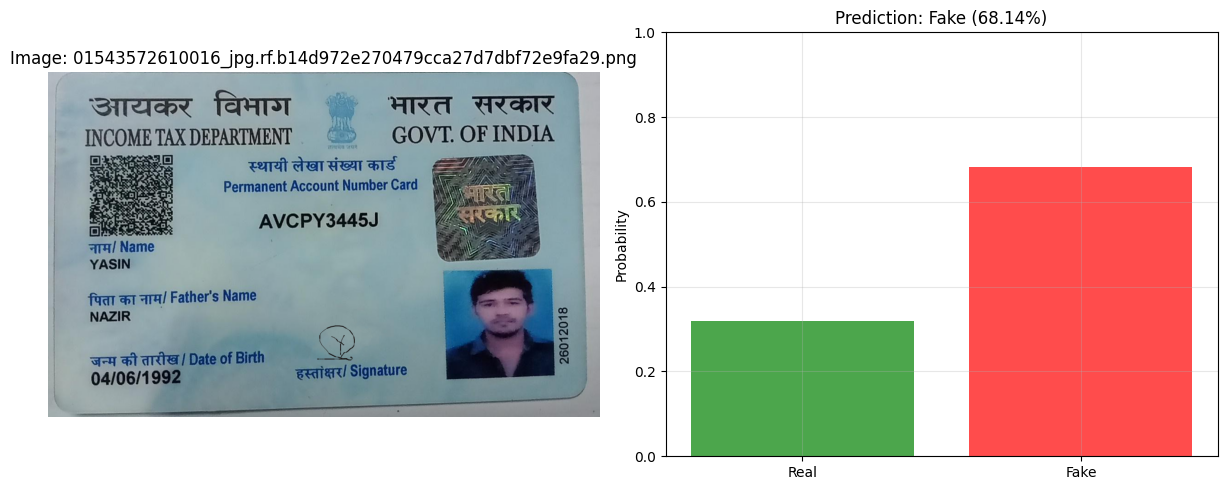

{
  "image_path": "/kaggle/input/pan-card-images-dataset/PAN dataset/Fake/01543572610016_jpg.rf.b14d972e270479cca27d7dbf72e9fa29.png",
  "prediction": "Fake",
  "confidence": 0.6813930869102478,
  "fake_probability": 0.6813930869102478,
  "real_probability": 0.3186069428920746
}


In [4]:
"""
Inference Script for PAN Card Tampering Detection
Use trained models to predict on new images
"""

import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import json
import pickle


class InferenceConfig:
    """Configuration for inference"""
    MODEL_DIR = '/kaggle/working/outputs/models'
    OUTPUT_DIR = '/kaggle/working/predictions'
    IMG_SIZE = 384
    BATCH_SIZE = 8
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    USE_TTA = True  # Test-time augmentation
    TTA_TRANSFORMS = 5
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)


class InferenceDataset(Dataset):
    """Dataset for inference"""
    
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        
        return image, img_path


def get_inference_transforms():
    """Standard inference transforms"""
    return A.Compose([
        A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


def get_tta_transforms():
    """Test-time augmentation transforms"""
    return [
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.HorizontalFlip(p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.Rotate(limit=5, p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        A.Compose([
            A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
            A.GaussianBlur(blur_limit=(3, 3), p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    ]


class ModelEnsemble:
    """Ensemble of trained models for inference"""
    
    def __init__(self, model_dir, specific_models=None):
        self.model_dir = model_dir
        self.models = []
        self.device = InferenceConfig.DEVICE
        self.specific_models = specific_models  # List of specific model names to load
    
    def load_models(self, model_paths=None):
        """Load all trained models"""
        
        if model_paths is None:
            # Auto-discover models
            all_files = [f for f in os.listdir(self.model_dir) if f.endswith('.pth')]
            
            # Filter to specific models if provided
            if self.specific_models:
                model_paths = []
                for model_name in self.specific_models:
                    matching = [f for f in all_files if model_name in f]
                    if matching:
                        model_paths.append(os.path.join(self.model_dir, matching[0]))
                print(f"Using {len(model_paths)} specific models: {self.specific_models}")
            else:
                model_paths = [os.path.join(self.model_dir, f) for f in all_files]
        
        print(f"Loading {len(model_paths)} models...")
        
        for model_path in tqdm(model_paths, desc="Loading models"):
            # Extract model name from filename
            filename = os.path.basename(model_path)
            model_name = filename.split('_fold')[0]
            
            try:
                model = PANCardClassifier(model_name=model_name, pretrained=False)
                
                # Try multiple loading methods
                checkpoint = None
                try:
                    checkpoint = torch.load(model_path, map_location=self.device)
                except:
                    try:
                        checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
                    except Exception as e:
                        print(f"  ✗ Failed to load {filename}: {e}")
                        continue
                
                if checkpoint is None:
                    continue
                
                # Extract state dict
                if 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'])
                    accuracy = checkpoint.get('accuracy', 0)
                else:
                    model.load_state_dict(checkpoint)
                    accuracy = 0
                
                model = model.to(self.device)
                model.eval()
                
                self.models.append({
                    'model': model,
                    'name': model_name,
                    'path': model_path,
                    'accuracy': accuracy
                })
                
                print(f"  ✓ {filename} (Acc: {accuracy:.2f}%)")
                
            except Exception as e:
                print(f"  ✗ Error loading {filename}: {e}")
        
        print(f"\nSuccessfully loaded {len(self.models)} models")
        return len(self.models) > 0
    
    def predict_single_image(self, image_tensor, use_tta=False):
        """Predict on single image with optional TTA"""
        predictions = []
        
        if not use_tta:
            # Standard prediction
            image_tensor = image_tensor.unsqueeze(0).to(self.device)
            with torch.no_grad():
                for model_info in self.models:
                    outputs = model_info['model'](image_tensor)
                    probs = F.softmax(outputs, dim=1)
                    predictions.append(probs.cpu().numpy())
        else:
            # Test-time augmentation
            tta_transforms = get_tta_transforms()
            tta_predictions = []
            
            # Get original image as numpy
            img_np = image_tensor.permute(1, 2, 0).numpy()
            img_np = ((img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]) * 255
            img_np = img_np.astype(np.uint8)
            
            for transform in tta_transforms:
                aug_img = transform(image=img_np)['image']
                aug_img = aug_img.unsqueeze(0).to(self.device)
                
                with torch.no_grad():
                    for model_info in self.models:
                        outputs = model_info['model'](aug_img)
                        probs = F.softmax(outputs, dim=1)
                        tta_predictions.append(probs.cpu().numpy())
            
            # Average TTA predictions
            predictions = [np.mean(tta_predictions, axis=0)]
        
        # Average across all models
        avg_prediction = np.mean(predictions, axis=0)
        return avg_prediction
    
    def predict_batch(self, dataloader, use_tta=False):
        """Predict on batch of images"""
        all_predictions = []
        all_image_paths = []
        
        print("Generating predictions...")
        for images, img_paths in tqdm(dataloader, desc="Inference"):
            images = images.to(self.device)
            batch_predictions = []
            
            with torch.no_grad():
                for model_info in self.models:
                    outputs = model_info['model'](images)
                    probs = F.softmax(outputs, dim=1)
                    batch_predictions.append(probs.cpu().numpy())
            
            # Average predictions across models
            avg_batch_preds = np.mean(batch_predictions, axis=0)
            all_predictions.append(avg_batch_preds)
            all_image_paths.extend(img_paths)
        
        # Concatenate all batches
        all_predictions = np.vstack(all_predictions)
        return all_predictions, all_image_paths


class ForensicPredictor:
    """Use forensic features for prediction"""
    
    def __init__(self):
        self.feature_extractor = None
        self.meta_learner = None
    
    def load_components(self, feature_extractor_path=None, meta_learner_path=None):
        """Load forensic feature extractor and meta-learner"""
        from forensic_features import ForensicFeatureExtractor, MetaLearnerEnsemble
        
        self.feature_extractor = ForensicFeatureExtractor()
        self.meta_learner = MetaLearnerEnsemble()
        
        if meta_learner_path and os.path.exists(meta_learner_path):
            self.meta_learner.load(meta_learner_path)
            print("Meta-learner loaded successfully")
    
    def extract_features(self, image_paths):
        """Extract forensic features from images"""
        features = []
        for img_path in tqdm(image_paths, desc="Extracting forensic features"):
            img_features = self.feature_extractor.extract_all_features(img_path)
            if img_features:
                features.append(img_features)
        
        return pd.DataFrame(features)
    
    def predict(self, cnn_predictions, forensic_features):
        """Make final prediction combining CNN and forensic features"""
        if self.meta_learner is None:
            print("Warning: Meta-learner not loaded, using CNN predictions only")
            return cnn_predictions
        
        # Prepare features for meta-learner
        # This should match the format used during training
        meta_features = np.concatenate([cnn_predictions, forensic_features], axis=1)
        
        predictions, probabilities = self.meta_learner.predict(meta_features)
        return predictions, probabilities


def predict_on_images(image_paths, output_csv=None, use_tta=True, use_forensics=False, 
                     specific_models=None):
    """
    Main prediction function
    
    Args:
        image_paths: List of image paths to predict
        output_csv: Path to save predictions CSV
        use_tta: Whether to use test-time augmentation
        use_forensics: Whether to use forensic features and meta-learner
        specific_models: List of specific model names to use (e.g., ['convnext_base_fold2', 'swin_base_patch4_window12_384_fold2'])
    """
    
    print("="*60)
    print("PAN CARD TAMPERING DETECTION - INFERENCE")
    print("="*60)
    print(f"Number of images: {len(image_paths)}")
    print(f"Device: {InferenceConfig.DEVICE}")
    print(f"Use TTA: {use_tta}")
    print(f"Use Forensics: {use_forensics}")
    if specific_models:
        print(f"Specific models: {specific_models}")
    
    # Load CNN ensemble
    ensemble = ModelEnsemble(InferenceConfig.MODEL_DIR, specific_models=specific_models)
    if not ensemble.load_models():
        print("Error: No models found!")
        return None
    
    # Create dataset and dataloader
    dataset = InferenceDataset(image_paths, transforms=get_inference_transforms())
    dataloader = DataLoader(
        dataset,
        batch_size=InferenceConfig.BATCH_SIZE,
        shuffle=False,
        num_workers=4
    )
    
    # Get CNN predictions
    cnn_predictions, img_paths = ensemble.predict_batch(dataloader, use_tta=use_tta)
    
    # Optionally use forensic features
    if use_forensics:
        forensic_predictor = ForensicPredictor()
        meta_learner_path = os.path.join(InferenceConfig.MODEL_DIR, 'meta_learner_fold0.pkl')
        
        if os.path.exists(meta_learner_path):
            forensic_predictor.load_components(meta_learner_path=meta_learner_path)
            forensic_features = forensic_predictor.extract_features(image_paths)
            
            # Combine predictions
            final_predictions, final_probs = forensic_predictor.predict(
                cnn_predictions[:, 1:2],  # Use only class 1 probability
                forensic_features.values
            )
        else:
            print("Warning: Meta-learner not found, using CNN predictions only")
            final_predictions = np.argmax(cnn_predictions, axis=1)
            final_probs = cnn_predictions[:, 1]
    else:
        final_predictions = np.argmax(cnn_predictions, axis=1)
        final_probs = cnn_predictions[:, 1]
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'image_path': img_paths,
        'prediction': final_predictions,
        'prediction_label': ['Real' if p == 0 else 'Fake' for p in final_predictions],
        'fake_probability': final_probs,
        'confidence': np.max(cnn_predictions, axis=1)
    })
    
    # Summary statistics
    print("\n" + "="*60)
    print("PREDICTION SUMMARY")
    print("="*60)
    print(f"Total images: {len(results_df)}")
    print(f"Predicted Real: {np.sum(final_predictions == 0)}")
    print(f"Predicted Fake: {np.sum(final_predictions == 1)}")
    print(f"Average confidence: {results_df['confidence'].mean():.4f}")
    
    # Save results
    if output_csv:
        results_df.to_csv(output_csv, index=False)
        print(f"\nResults saved to: {output_csv}")
    
    return results_df


def predict_single_image_detailed(image_path, show_visualization=True):
    """
    Predict on single image with detailed output
    
    Args:
        image_path: Path to image
        show_visualization: Whether to show visualization
    
    Returns:
        dict with detailed prediction results
    """
    
    # Load models
    ensemble = ModelEnsemble(InferenceConfig.MODEL_DIR)
    ensemble.load_models()
    
    # Load and preprocess image
    transforms = get_inference_transforms()
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    augmented = transforms(image=image_rgb)
    image_tensor = augmented['image']
    
    # Get prediction
    prediction = ensemble.predict_single_image(image_tensor, use_tta=InferenceConfig.USE_TTA)
    
    pred_class = np.argmax(prediction)
    pred_prob = prediction[0, pred_class]
    fake_prob = prediction[0, 1]
    
    result = {
        'image_path': image_path,
        'prediction': 'Fake' if pred_class == 1 else 'Real',
        'confidence': float(pred_prob),
        'fake_probability': float(fake_prob),
        'real_probability': float(prediction[0, 0])
    }
    
    if show_visualization:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Show image
        axes[0].imshow(image_rgb)
        axes[0].set_title(f'Image: {os.path.basename(image_path)}')
        axes[0].axis('off')
        
        # Show prediction
        colors = ['green', 'red']
        axes[1].bar(['Real', 'Fake'], prediction[0], color=colors, alpha=0.7)
        axes[1].set_ylabel('Probability')
        axes[1].set_title(f'Prediction: {result["prediction"]} ({result["confidence"]:.2%})')
        axes[1].set_ylim([0, 1])
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(
            os.path.join(InferenceConfig.OUTPUT_DIR, f'prediction_{os.path.basename(image_path)}'),
            dpi=150,
            bbox_inches='tight'
        )
        plt.show()
    
    return result

class PANCardClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b4', pretrained=True):
        super(PANCardClassifier, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=2)
    def forward(self, x):
        return self.model(x)

def main():
    """Example usage"""
    
    # IMPORTANT: Specify only the working models
    WORKING_MODELS = [
        'convnext_base_fold2',
        'convnext_base_fold4',
        'swin_base_patch4_window12_384_fold2',
        'swin_base_patch4_window12_384_fold3'
    ]
    
    # Predict on list of images with specific models
    image_paths = [
        '/kaggle/input/pan-card-images-dataset/PAN dataset/Real/0085aec6-imgtopdf_generated_2508201310016_page-32_jpg.rf.40f993f3a8c866fa4639f6f516899f56.jpg',
        '/kaggle/input/pan-card-images-dataset/PAN dataset/Real/01111534630016_jpg.rf.1964911aa025e7ed4caf55f3ea8c0c8a.jpg',
    ]
    
    results = predict_on_images(
        image_paths,
        output_csv=os.path.join(InferenceConfig.OUTPUT_DIR, 'predictions.csv'),
        use_tta=True,
        use_forensics=False,
        specific_models=WORKING_MODELS  # Use only working models
    )
    
    if results is not None:
        print("\nPrediction results:")
        print(results)
    
    # Predict on single image with visualization
    result = predict_single_image_detailed(
        '/kaggle/input/pan-card-images-dataset/PAN dataset/Fake/01543572610016_jpg.rf.b14d972e270479cca27d7dbf72e9fa29.png',
        show_visualization=True
    )
    print(json.dumps(result, indent=2))


if __name__ == "__main__":
    main()

Device: cuda
Working Models: ['convnext_base_fold2', 'convnext_base_fold4', 'swin_base_patch4_window12_384_fold2', 'swin_base_patch4_window12_384_fold3']
PAN CARD DETECTION - INFERENCE WITH VISUALIZATION
Using only 4 working models: ['convnext_base_fold2', 'convnext_base_fold4', 'swin_base_patch4_window12_384_fold2', 'swin_base_patch4_window12_384_fold3']

ANALYZING: Tampered_141.jpg

Loading 4 working models...
  ✓ convnext_base_fold2 (Acc: 93.50%)
  ✓ convnext_base_fold4 (Acc: 94.47%)
  ✓ swin_base_patch4_window12_384_fold2 (Acc: 95.00%)
  ✓ swin_base_patch4_window12_384_fold3 (Acc: 94.47%)

Successfully loaded 4 models

Getting predictions from models...
Extracting text with OCR...

Prediction: Fake
Confidence: 85.35%
OCR Text: 314r fat HRT rTr INCOME TAX DEPARTMENT GOVT OF INDIA TIe TI HG TT3 Permanent Account Number Card HZG...
PAN Numbers: ['HZGPK9977L']

Generating comprehensive visualization...
Visualization saved: /kaggle/working/predictions/analysis_Tampered_141.jpg.png


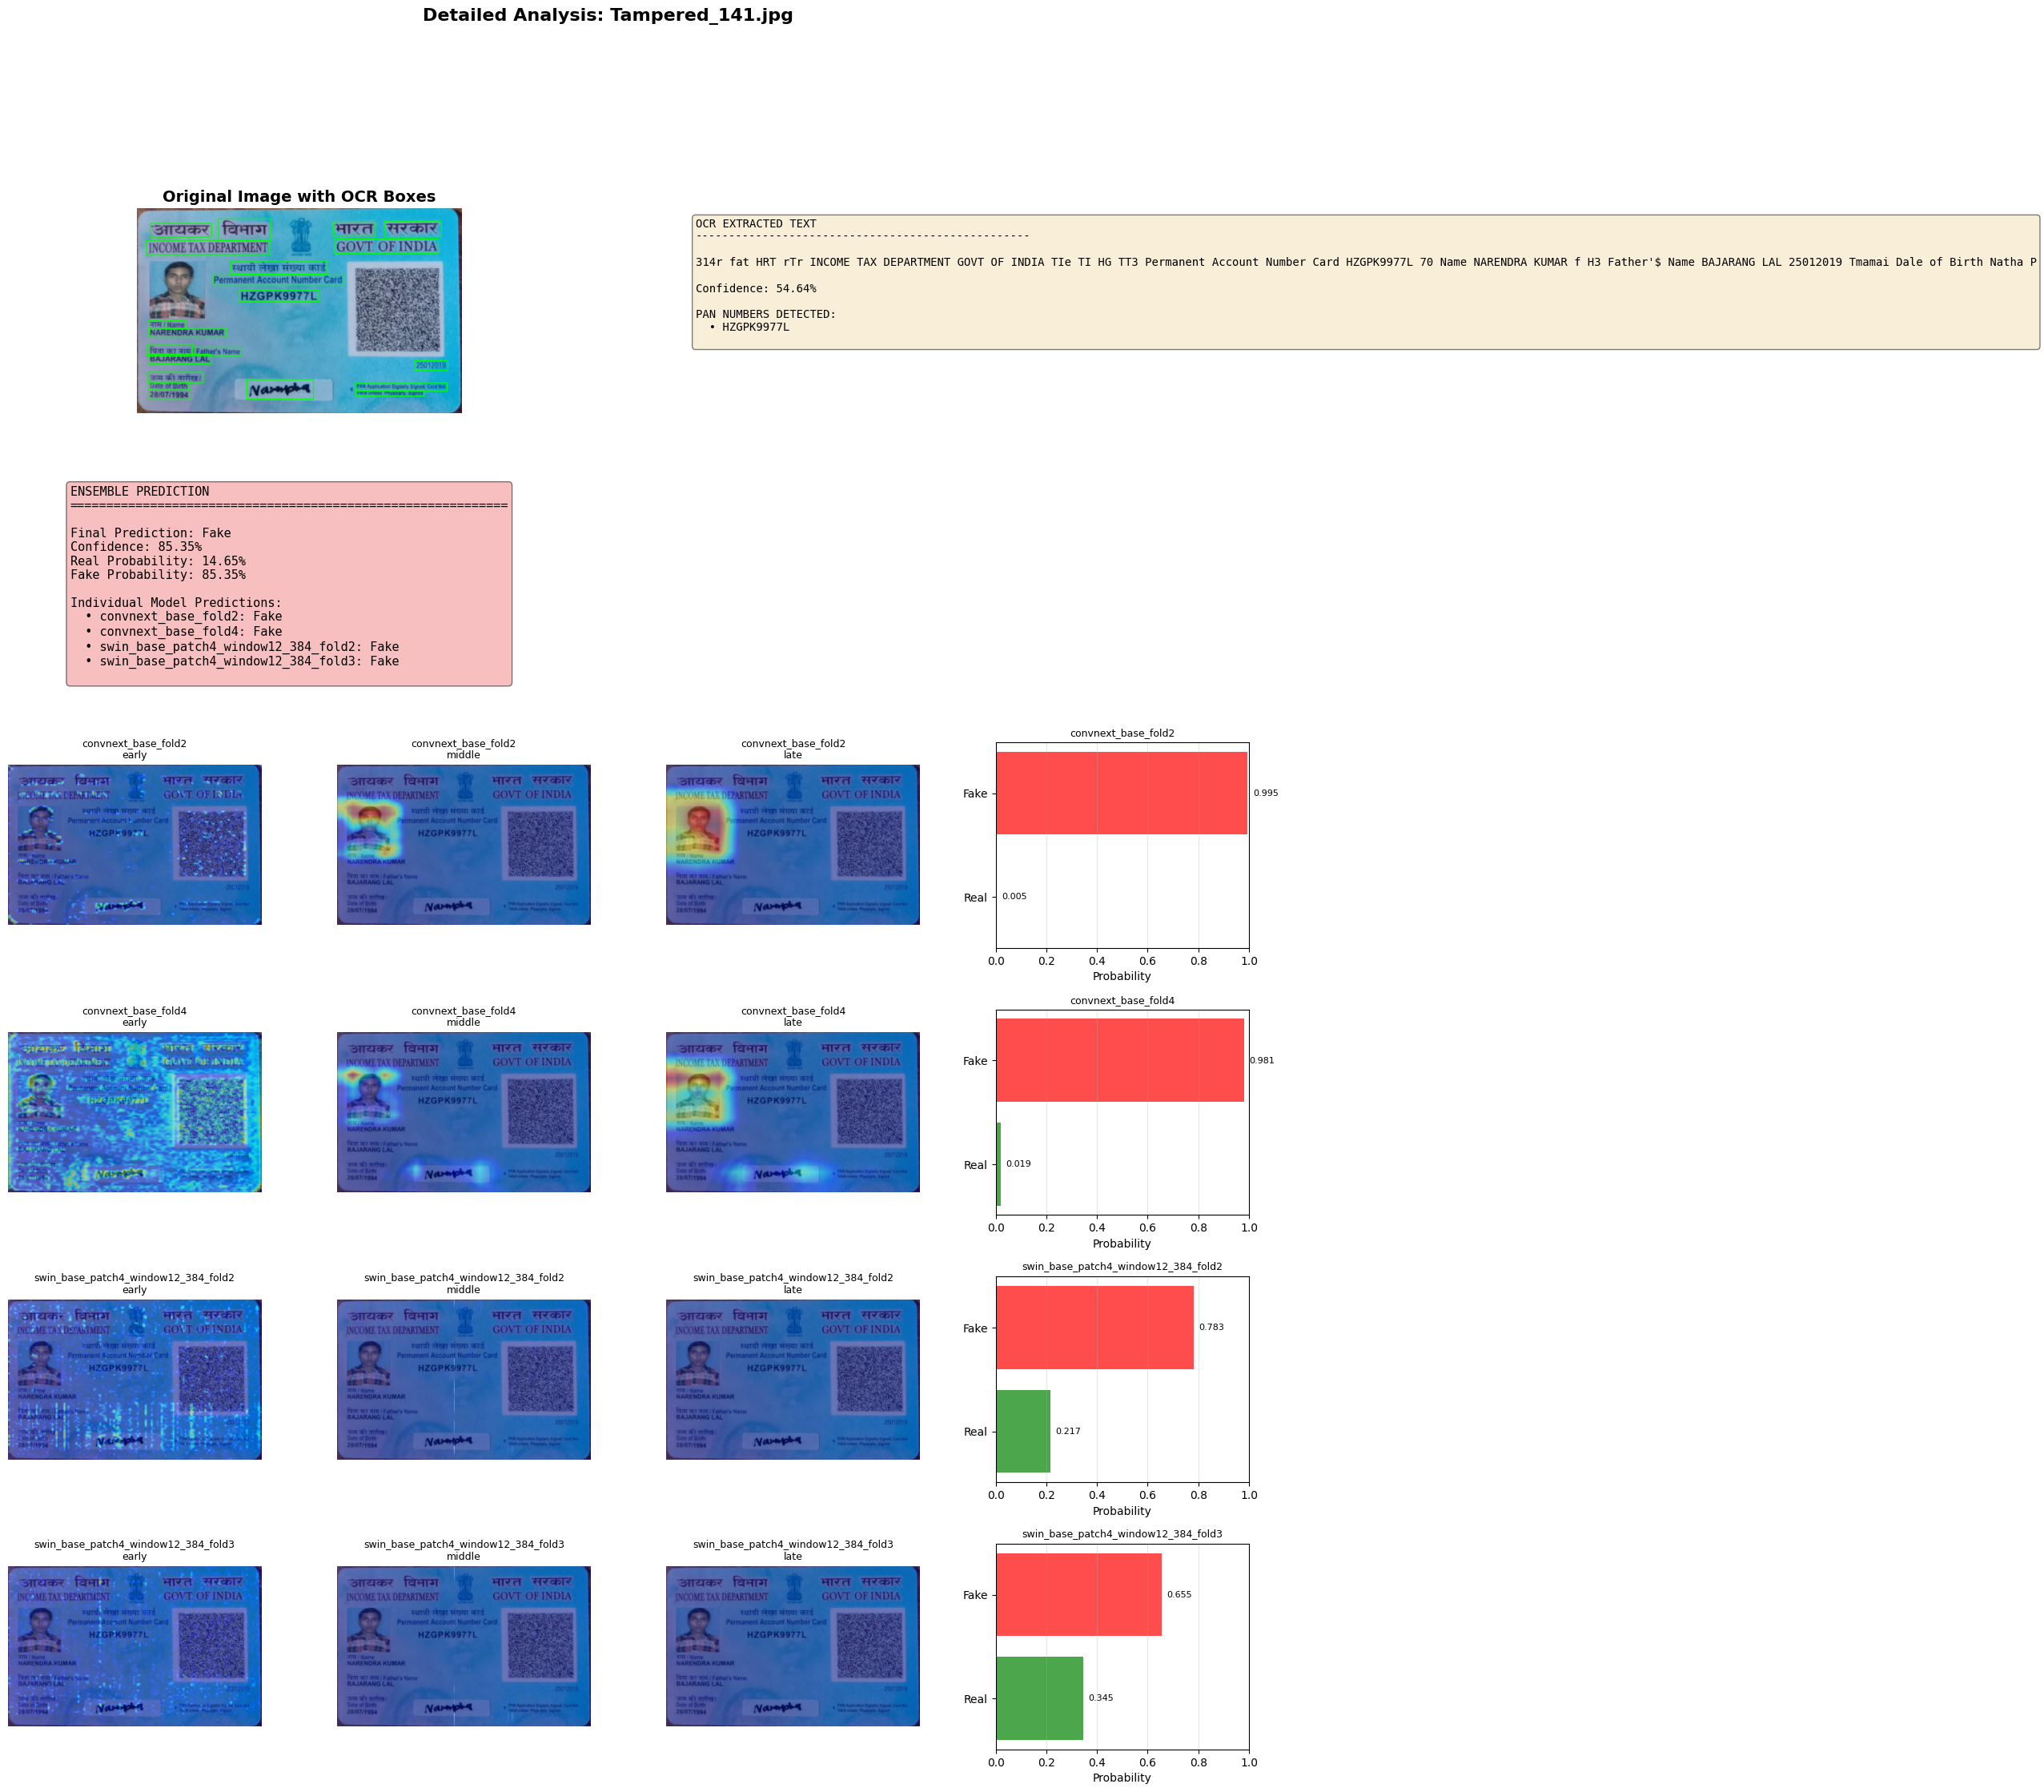


FINAL RESULT
{
  "image_path": "/kaggle/input/pan-card-images-dataset/PAN dataset/Fake/Tampered_141.jpg",
  "prediction": "Fake",
  "confidence": 0.8534873723983765,
  "fake_probability": 0.8534873723983765,
  "real_probability": 0.14651267230510712,
  "individual_predictions": {
    "convnext_base_fold2": "Fake",
    "convnext_base_fold4": "Fake",
    "swin_base_patch4_window12_384_fold2": "Fake",
    "swin_base_patch4_window12_384_fold3": "Fake"
  },
  "ocr_text": "314r fat HRT rTr INCOME TAX DEPARTMENT GOVT OF INDIA TIe TI HG TT3 Permanent Account Number Card HZGPK9977L 70 Name NARENDRA KUMAR f H3 Father'$ Name BAJARANG LAL 25012019 Tmamai Dale of Birth Natha PAN Aeplicaton Digilslly $ oncd Garno 28/07/1994 Yallid unleas Pnnercalln saned",
  "ocr_confidence": 0.546445092354505,
  "pan_numbers_found": [
    "HZGPK9977L"
  ]
}


In [8]:
"""
Complete Inference Script for PAN Card Tampering Detection
Includes GradCAM visualization, OCR text extraction, and uses only working models
"""

import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Try importing OCR libraries
try:
    import pytesseract
    TESSERACT_AVAILABLE = True
except:
    TESSERACT_AVAILABLE = False
    print("Warning: pytesseract not available")

try:
    import easyocr
    EASYOCR_AVAILABLE = True
except:
    EASYOCR_AVAILABLE = False
    print("Warning: easyocr not available. Install with: pip install easyocr")

# Initialize EasyOCR reader
if EASYOCR_AVAILABLE:
    try:
        reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
    except:
        reader = None
else:
    reader = None


class InferenceConfig:
    """Configuration for inference"""
    MODEL_DIR = '/kaggle/working/outputs/models'
    OUTPUT_DIR = '/kaggle/working/predictions'
    IMG_SIZE = 384
    BATCH_SIZE = 8
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # ONLY THESE 4 WORKING MODELS
    WORKING_MODELS = [
        'convnext_base_fold2',
        'convnext_base_fold4',
        'swin_base_patch4_window12_384_fold2',
        'swin_base_patch4_window12_384_fold3'
    ]
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)


print(f"Device: {InferenceConfig.DEVICE}")
print(f"Working Models: {InferenceConfig.WORKING_MODELS}")


# Import timm and albumentations
try:
    import timm
except:
    print("Installing timm...")
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'timm'])
    import timm


def get_inference_transforms():
    """Standard inference transforms"""
    return A.Compose([
        A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


class InferenceDataset(Dataset):
    """Dataset for inference"""
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        
        return image, img_path


class PANCardClassifier(nn.Module):
    """Model architecture"""
    def __init__(self, model_name='convnext_base', pretrained=True):
        super(PANCardClassifier, self).__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=2)
        
    def forward(self, x):
        return self.model(x)


class GradCAM:
    """GradCAM visualization"""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        """Generate GradCAM heatmap"""
        self.model.eval()
        
        output = self.model(input_image)
        
        if target_class is None:
            target_class = output.argmax(dim=1)
        
        self.model.zero_grad()
        class_loss = output[0, target_class]
        class_loss.backward()
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
        
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap = heatmap / (torch.max(heatmap) + 1e-8)
        
        return heatmap.cpu().numpy()


def get_target_layers(model, model_name):
    """Get target layers for GradCAM"""
    layers = {}
    
    try:
        if 'convnext' in model_name.lower():
            layers['early'] = model.model.stages[0]
            layers['middle'] = model.model.stages[2]
            layers['late'] = model.model.stages[3]
        elif 'swin' in model_name.lower():
            layers['early'] = model.model.layers[0]
            layers['middle'] = model.model.layers[2]
            layers['late'] = model.model.layers[3]
        elif 'efficientnet' in model_name.lower():
            layers['early'] = model.model.blocks[2]
            layers['middle'] = model.model.blocks[4]
            layers['late'] = model.model.blocks[6]
    except:
        # Fallback
        try:
            layers['default'] = list(model.modules())[-3]
        except:
            layers['default'] = model
    
    return layers


def extract_text_from_image(image_path):
    """Extract text using OCR"""
    results = {
        'text': '',
        'bounding_boxes': [],
        'confidence': 0.0
    }
    
    try:
        image = cv2.imread(image_path)
        if image is None:
            return results
        
        if EASYOCR_AVAILABLE and reader is not None:
            ocr_results = reader.readtext(image)
            
            all_text = []
            boxes = []
            confidences = []
            
            for detection in ocr_results:
                bbox, text, conf = detection
                all_text.append(text)
                boxes.append(bbox)
                confidences.append(conf)
            
            results['text'] = ' '.join(all_text)
            results['bounding_boxes'] = boxes
            results['confidence'] = np.mean(confidences) if confidences else 0.0
        
        elif TESSERACT_AVAILABLE:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
            
            all_text = []
            boxes = []
            confidences = []
            
            for i, word in enumerate(data['text']):
                if word.strip():
                    conf = int(data['conf'][i])
                    if conf > 0:
                        all_text.append(word)
                        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
                        boxes.append([[x, y], [x+w, y], [x+w, y+h], [x, y+h]])
                        confidences.append(conf / 100.0)
            
            results['text'] = ' '.join(all_text)
            results['bounding_boxes'] = boxes
            results['confidence'] = np.mean(confidences) if confidences else 0.0
        else:
            results['text'] = "OCR not available"
    
    except Exception as e:
        results['text'] = f"OCR error: {str(e)}"
    
    return results


def validate_pan_number(text):
    """Validate PAN number format"""
    import re
    pan_pattern = re.compile(r'[A-Z]{5}[0-9]{4}[A-Z]')
    matches = pan_pattern.findall(text.upper())
    return matches


class ModelEnsemble:
    """Ensemble of working models only"""
    
    def __init__(self, model_dir):
        self.model_dir = model_dir
        self.models = []
        self.device = InferenceConfig.DEVICE
    
    def load_models(self):
        """Load only the 4 working models"""
        print(f"\nLoading {len(InferenceConfig.WORKING_MODELS)} working models...")
        
        for model_name in InferenceConfig.WORKING_MODELS:
            # Find matching file
            matching_files = [f for f in os.listdir(self.model_dir) 
                            if f.endswith('.pth') and model_name in f]
            
            if not matching_files:
                print(f"  ✗ Model file not found for: {model_name}")
                continue
            
            model_file = matching_files[0]
            model_path = os.path.join(self.model_dir, model_file)
            
            # Determine architecture
            if 'convnext' in model_name.lower():
                arch = 'convnext_base'
            elif 'swin' in model_name.lower():
                arch = 'swin_base_patch4_window12_384'
            else:
                print(f"  ✗ Unknown architecture for: {model_name}")
                continue
            
            try:
                model = PANCardClassifier(model_name=arch, pretrained=False)
                
                # Try loading
                try:
                    checkpoint = torch.load(model_path, map_location=self.device)
                except:
                    checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
                
                if 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'])
                    accuracy = checkpoint.get('accuracy', 0)
                else:
                    model.load_state_dict(checkpoint)
                    accuracy = 0
                
                model = model.to(self.device)
                model.eval()
                
                self.models.append({
                    'model': model,
                    'name': model_name,
                    'arch': arch,
                    'path': model_path,
                    'accuracy': accuracy
                })
                
                print(f"  ✓ {model_name} (Acc: {accuracy:.2f}%)")
                
            except Exception as e:
                print(f"  ✗ Failed to load {model_name}: {e}")
        
        print(f"\nSuccessfully loaded {len(self.models)} models")
        return len(self.models) > 0


def predict_batch(ensemble, dataloader):
    """Batch prediction using ensemble"""
    all_predictions = []
    all_probs = []
    all_paths = []
    
    print("\nGenerating predictions...")
    
    with torch.no_grad():
        for images, paths in tqdm(dataloader, desc='Predicting'):
            images = images.to(InferenceConfig.DEVICE)
            
            batch_probs = []
            for model_info in ensemble.models:
                model = model_info['model']
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                batch_probs.append(probs.cpu().numpy())
            
            # Average across models
            avg_probs = np.mean(batch_probs, axis=0)
            predictions = np.argmax(avg_probs, axis=1)
            
            all_predictions.extend(predictions)
            all_probs.extend(avg_probs[:, 1])
            all_paths.extend(paths)
    
    return all_predictions, all_probs, all_paths


def predict_on_images(image_paths, output_csv=None):
    """
    Batch prediction on multiple images using only working models
    
    Args:
        image_paths: List of image paths
        output_csv: Path to save results
    """
    
    print("="*70)
    print("BATCH PREDICTION - USING 4 WORKING MODELS")
    print("="*70)
    print(f"Images: {len(image_paths)}")
    print(f"Models: {InferenceConfig.WORKING_MODELS}")
    
    # Load models
    ensemble = ModelEnsemble(InferenceConfig.MODEL_DIR)
    if not ensemble.load_models():
        print("ERROR: No models loaded!")
        return None
    
    # Create dataset
    dataset = InferenceDataset(image_paths, transforms=get_inference_transforms())
    dataloader = DataLoader(dataset, batch_size=InferenceConfig.BATCH_SIZE, 
                           shuffle=False, num_workers=2)
    
    # Predict
    predictions, probabilities, paths = predict_batch(ensemble, dataloader)
    
    # Create results
    results_df = pd.DataFrame({
        'image_path': paths,
        'prediction': ['Fake' if p == 1 else 'Real' for p in predictions],
        'fake_probability': probabilities,
        'confidence': [probabilities[i] if predictions[i] == 1 else 1-probabilities[i] 
                      for i in range(len(predictions))]
    })
    
    # Summary
    print("\n" + "="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    print(f"Total images: {len(results_df)}")
    print(f"Predicted Real: {np.sum(predictions == 0)}")
    print(f"Predicted Fake: {np.sum(predictions == 1)}")
    print(f"Average confidence: {results_df['confidence'].mean():.2%}")
    
    if output_csv:
        results_df.to_csv(output_csv, index=False)
        print(f"\nResults saved: {output_csv}")
    
    return results_df


def predict_single_image_detailed(image_path, show_visualization=True):
    """
    Detailed prediction with GradCAM and OCR for single image
    Uses only the 4 working models
    """
    
    print("\n" + "="*70)
    print(f"ANALYZING: {os.path.basename(image_path)}")
    print("="*70)
    
    if not os.path.exists(image_path):
        print(f"ERROR: Image not found: {image_path}")
        return None
    
    # Load models
    ensemble = ModelEnsemble(InferenceConfig.MODEL_DIR)
    if not ensemble.load_models():
        return None
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"ERROR: Could not read image")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Transform
    transforms = get_inference_transforms()
    augmented = transforms(image=image_rgb)
    image_tensor = augmented['image']
    
    # Get predictions from all models
    print("\nGetting predictions from models...")
    all_predictions = []
    all_probs = []
    
    with torch.no_grad():
        image_batch = image_tensor.unsqueeze(0).to(InferenceConfig.DEVICE)
        
        for model_info in ensemble.models:
            model = model_info['model']
            outputs = model(image_batch)
            probs = F.softmax(outputs, dim=1)
            
            pred = torch.argmax(probs, dim=1).item()
            all_predictions.append(pred)
            all_probs.append(probs[0].cpu().numpy())
    
    # Ensemble
    all_probs_array = np.array(all_probs)
    avg_probs = np.mean(all_probs_array, axis=0)
    ensemble_pred = np.argmax(avg_probs)
    ensemble_confidence = avg_probs[ensemble_pred]
    
    # OCR
    print("Extracting text with OCR...")
    ocr_results = extract_text_from_image(image_path)
    pan_numbers = validate_pan_number(ocr_results['text'])
    
    # Results
    result = {
        'image_path': image_path,
        'prediction': 'Fake' if ensemble_pred == 1 else 'Real',
        'confidence': float(ensemble_confidence),
        'fake_probability': float(avg_probs[1]),
        'real_probability': float(avg_probs[0]),
        'individual_predictions': {
            ensemble.models[i]['name']: 'Fake' if pred == 1 else 'Real'
            for i, pred in enumerate(all_predictions)
        },
        'ocr_text': ocr_results['text'],
        'ocr_confidence': float(ocr_results['confidence']),
        'pan_numbers_found': pan_numbers
    }
    
    print(f"\nPrediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"OCR Text: {ocr_results['text'][:100]}...")
    if pan_numbers:
        print(f"PAN Numbers: {pan_numbers}")
    
    if show_visualization:
        visualize_comprehensive(image_path, image_tensor, ensemble, result, ocr_results)
    
    return result


def visualize_comprehensive(image_path, image_tensor, ensemble, result, ocr_results):
    """Create comprehensive visualization with GradCAM and OCR"""
    
    print("\nGenerating comprehensive visualization...")
    
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    n_models = len(ensemble.models)
    
    # Create figure
    fig = plt.figure(figsize=(20, 5 * n_models + 5))
    gs = fig.add_gridspec(n_models + 2, 4, hspace=0.3, wspace=0.3)
    
    # Row 0: Original with OCR
    ax_orig = fig.add_subplot(gs[0, :2])
    img_with_boxes = original_image.copy()
    
    if ocr_results['bounding_boxes']:
        for bbox in ocr_results['bounding_boxes']:
            if len(bbox) >= 4:
                pts = np.array(bbox, dtype=np.int32).reshape((-1, 1, 2))
                cv2.polylines(img_with_boxes, [pts], True, (0, 255, 0), 2)
    
    ax_orig.imshow(img_with_boxes)
    ax_orig.set_title('Original Image with OCR Boxes', fontsize=14, fontweight='bold')
    ax_orig.axis('off')
    
    # Row 0: OCR Text
    ax_text = fig.add_subplot(gs[0, 2:])
    ax_text.axis('off')
    
    ocr_info = f"OCR EXTRACTED TEXT\n{'-'*50}\n\n"
    ocr_info += f"{ocr_results['text'][:200]}\n\n"
    ocr_info += f"Confidence: {ocr_results['confidence']:.2%}\n\n"
    
    if result['pan_numbers_found']:
        ocr_info += f"PAN NUMBERS DETECTED:\n"
        for pan in result['pan_numbers_found']:
            ocr_info += f"  • {pan}\n"
    else:
        ocr_info += "No valid PAN numbers detected"
    
    ax_text.text(0.05, 0.95, ocr_info, transform=ax_text.transAxes,
                fontsize=10, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Row 1: Prediction Summary
    ax_pred = fig.add_subplot(gs[1, :])
    ax_pred.axis('off')
    
    pred_text = f"ENSEMBLE PREDICTION\n{'='*60}\n\n"
    pred_text += f"Final Prediction: {result['prediction']}\n"
    pred_text += f"Confidence: {result['confidence']:.2%}\n"
    pred_text += f"Real Probability: {result['real_probability']:.2%}\n"
    pred_text += f"Fake Probability: {result['fake_probability']:.2%}\n\n"
    pred_text += "Individual Model Predictions:\n"
    for model_name, pred in result['individual_predictions'].items():
        pred_text += f"  • {model_name}: {pred}\n"
    
    color = 'lightgreen' if result['prediction'] == 'Real' else 'lightcoral'
    ax_pred.text(0.05, 0.95, pred_text, transform=ax_pred.transAxes,
                fontsize=11, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.5))
    
    # Rows 2+: GradCAM for each model
    for model_idx, model_info in enumerate(ensemble.models):
        model = model_info['model']
        model_name = model_info['name']
        
        row = model_idx + 2
        
        # Get layers
        target_layers = get_target_layers(model, model_info['arch'])
        layer_names = list(target_layers.keys())[:3]
        
        for col_idx, layer_name in enumerate(layer_names):
            if col_idx >= 3:
                break
            
            ax = fig.add_subplot(gs[row, col_idx])
            
            try:
                target_layer = target_layers[layer_name]
                gradcam = GradCAM(model, target_layer)
                
                image_batch = image_tensor.unsqueeze(0).to(InferenceConfig.DEVICE)
                image_batch.requires_grad = True
                
                heatmap = gradcam.generate_cam(image_batch)
                heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
                
                heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
                heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
                
                overlay = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)
                
                ax.imshow(overlay)
                ax.set_title(f'{model_name}\n{layer_name}', fontsize=9)
                ax.axis('off')
                
            except Exception as e:
                ax.text(0.5, 0.5, f'GradCAM\nError', ha='center', va='center', fontsize=8)
                ax.axis('off')
        
        # Probability bars
        ax_bar = fig.add_subplot(gs[row, 3])
        
        with torch.no_grad():
            image_batch = image_tensor.unsqueeze(0).to(InferenceConfig.DEVICE)
            outputs = model(image_batch)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
        
        ax_bar.barh(['Real', 'Fake'], probs, color=['green', 'red'], alpha=0.7)
        ax_bar.set_xlim([0, 1])
        ax_bar.set_xlabel('Probability')
        ax_bar.set_title(f'{model_name}', fontsize=9)
        ax_bar.grid(True, alpha=0.3, axis='x')
        
        for i, prob in enumerate(probs):
            ax_bar.text(prob + 0.02, i, f'{prob:.3f}', va='center', fontsize=8)
    
    plt.suptitle(f'Detailed Analysis: {os.path.basename(image_path)}', 
                 fontsize=16, fontweight='bold')
    
    output_filename = f'analysis_{os.path.basename(image_path)}.png'
    output_path = os.path.join(InferenceConfig.OUTPUT_DIR, output_filename)
    plt.savefig(output_path, dpi=200, bbox_inches='tight')
    print(f"Visualization saved: {output_path}")
    
    plt.show()
    plt.close()


def main():
    """Main execution"""
    
    print("="*70)
    print("PAN CARD DETECTION - INFERENCE WITH VISUALIZATION")
    print("="*70)
    print(f"Using only 4 working models: {InferenceConfig.WORKING_MODELS}")
    
    # Example: Single image with full analysis
    image_path = '/kaggle/input/pan-card-images-dataset/PAN dataset/Fake/Tampered_141.jpg'  # UPDATE THIS
    
    if os.path.exists(image_path):
        result = predict_single_image_detailed(image_path, show_visualization=True)
        
        if result:
            print("\n" + "="*70)
            print("FINAL RESULT")
            print("="*70)
            print(json.dumps(result, indent=2))
    else:
        print(f"\nImage not found: {image_path}")
        print("Please update the path in main() function")
    
    # Example: Batch prediction
    """
    image_folder = '/kaggle/input/test-images/'
    image_paths = [os.path.join(image_folder, f) 
                   for f in os.listdir(image_folder) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    results = predict_on_images(image_paths, 
                                output_csv=os.path.join(InferenceConfig.OUTPUT_DIR, 'predictions.csv'))
    print(results)
    """


if __name__ == "__main__":
    main()